# Investigating how much changing $q$ makes a different, with a small value of $\sigma$

In [52]:
import numpy as np
import os 
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [53]:
print(sys.path)

['/Users/msharma/.local/share/virtualenvs/DP-PVI-uFKN1QRX/lib/python3.7/site-packages/ray/pyarrow_files', '/Users/msharma/workspace/DP-PVI/notebooks', '/Users/msharma/.local/share/virtualenvs/DP-PVI-uFKN1QRX/lib/python37.zip', '/Users/msharma/.local/share/virtualenvs/DP-PVI-uFKN1QRX/lib/python3.7', '/Users/msharma/.local/share/virtualenvs/DP-PVI-uFKN1QRX/lib/python3.7/lib-dynload', '/usr/local/Cellar/python/3.7.4/Frameworks/Python.framework/Versions/3.7/lib/python3.7', '', '/Users/msharma/.local/share/virtualenvs/DP-PVI-uFKN1QRX/lib/python3.7/site-packages', '/Users/msharma/.local/share/virtualenvs/DP-PVI-uFKN1QRX/lib/python3.7/site-packages/IPython/extensions', '/Users/msharma/.ipython', '/Users/msharma/workspace/DP-PVI', '/Users/msharma/.local/share/virtualenvs/DP-PVI-uFKN1QRX/lib/python3.7/site-packages/ray/modin']


In [2]:
import src.privacy.analysis.moment_accountant as ma
from src.privacy.analysis.moment_accountant.moment_accountant import _compute_eps
from src.privacy.analysis.moment_accountant.log_moment_utils import generate_log_moments
from src.privacy.analysis import PrivacyLedger
from src.privacy.analysis.pld_accountant import get_eps_add_remove_fixed_params

import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib as mpl

In [3]:
# plotting
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300

# fix quite a small signal to noise ratio
sigma = [1e-4, 1e-3, 1e-2, 0.1, 0.3, 0.5, 1]
q_s = np.logspace(-6, 0, 30)

results = []

E = 100
delta = 1e-7
max_lambda = 32

In [32]:
# directly use log moments here as it's the quickest
for sig in sigma:
    eps_vals = []
    for q in q_s:
#         print(f"Calculating for q={q}, sigma={sig}")
        eps = []
        N_iter = np.ceil(E * 1/q)
        log_moments = N_iter * generate_log_moments(q, sig, max_lambda)
        privacy = ma.get_privacy_spent(max_lambda, log_moments, None, delta)
#         privacy = get_eps_add_remove_fixed_params(target_delta=delta, sigma=sig, q=q, ncomp=N_iter, nx=2E6 L=100.0)
        eps, delta_ach = privacy
        eps_vals.append(eps)
    results.append((sig, eps_vals))

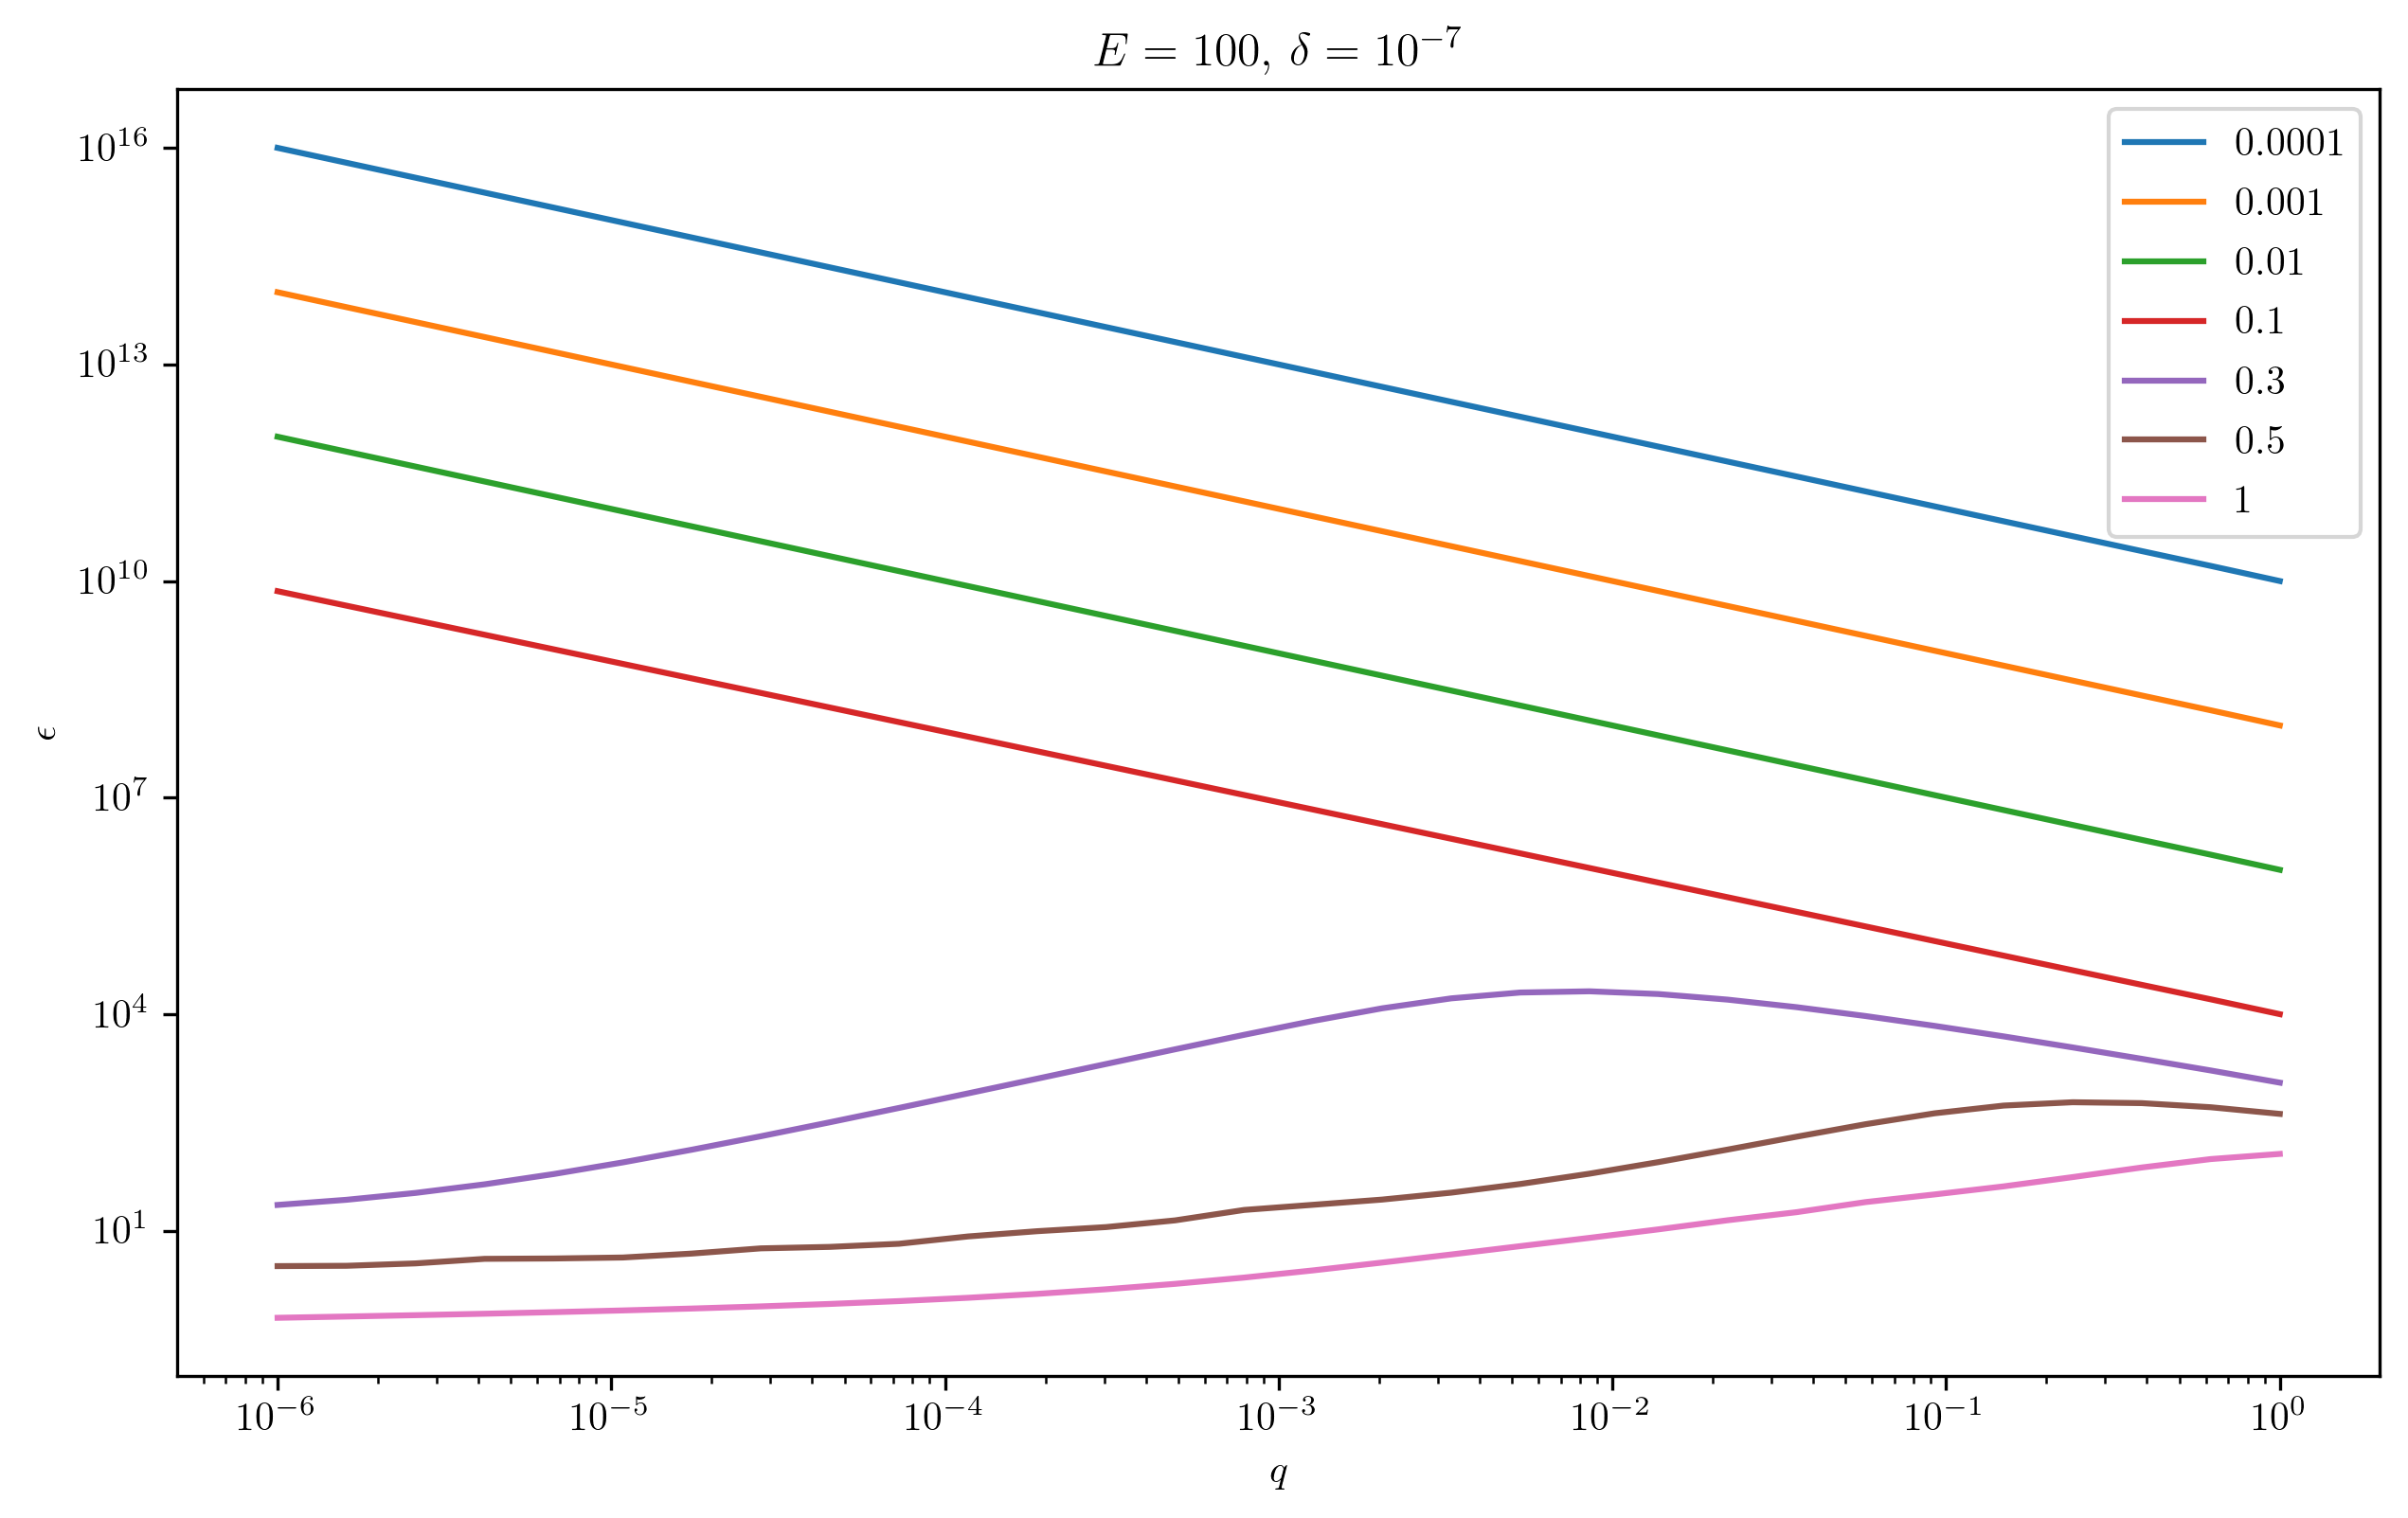

In [33]:
plt.figure(figsize=(10, 6))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
for sig, eps in results:
    plt.plot(q_s, eps)

ax = plt.gca()
ax.set_xscale("log")
ax.set_yscale("log")
plt.legend(sigma)
plt.xlabel('$q$')
plt.ylabel('$\epsilon$')
plt.title('$E=100$, $\delta=10^{-7}$')
plt.show()

Sadly, the moments accountant seems to break down completely when sigma is chosen too small? It's not entirely clear to me why this happens ... This happens when using the moment's accountant - but maybe we don't query the right value of $\lambda?!$. The issue is less so with the large privacy guarantees and moreso with the fact that as the $q$ increases, the privacy cost seems to go down.

This means that for the 'fixed' DP-PVI code, we would be unable to use $L=1$, as it probably would result in simply too much noise being added.

## For more reasonable values of $\sigma$

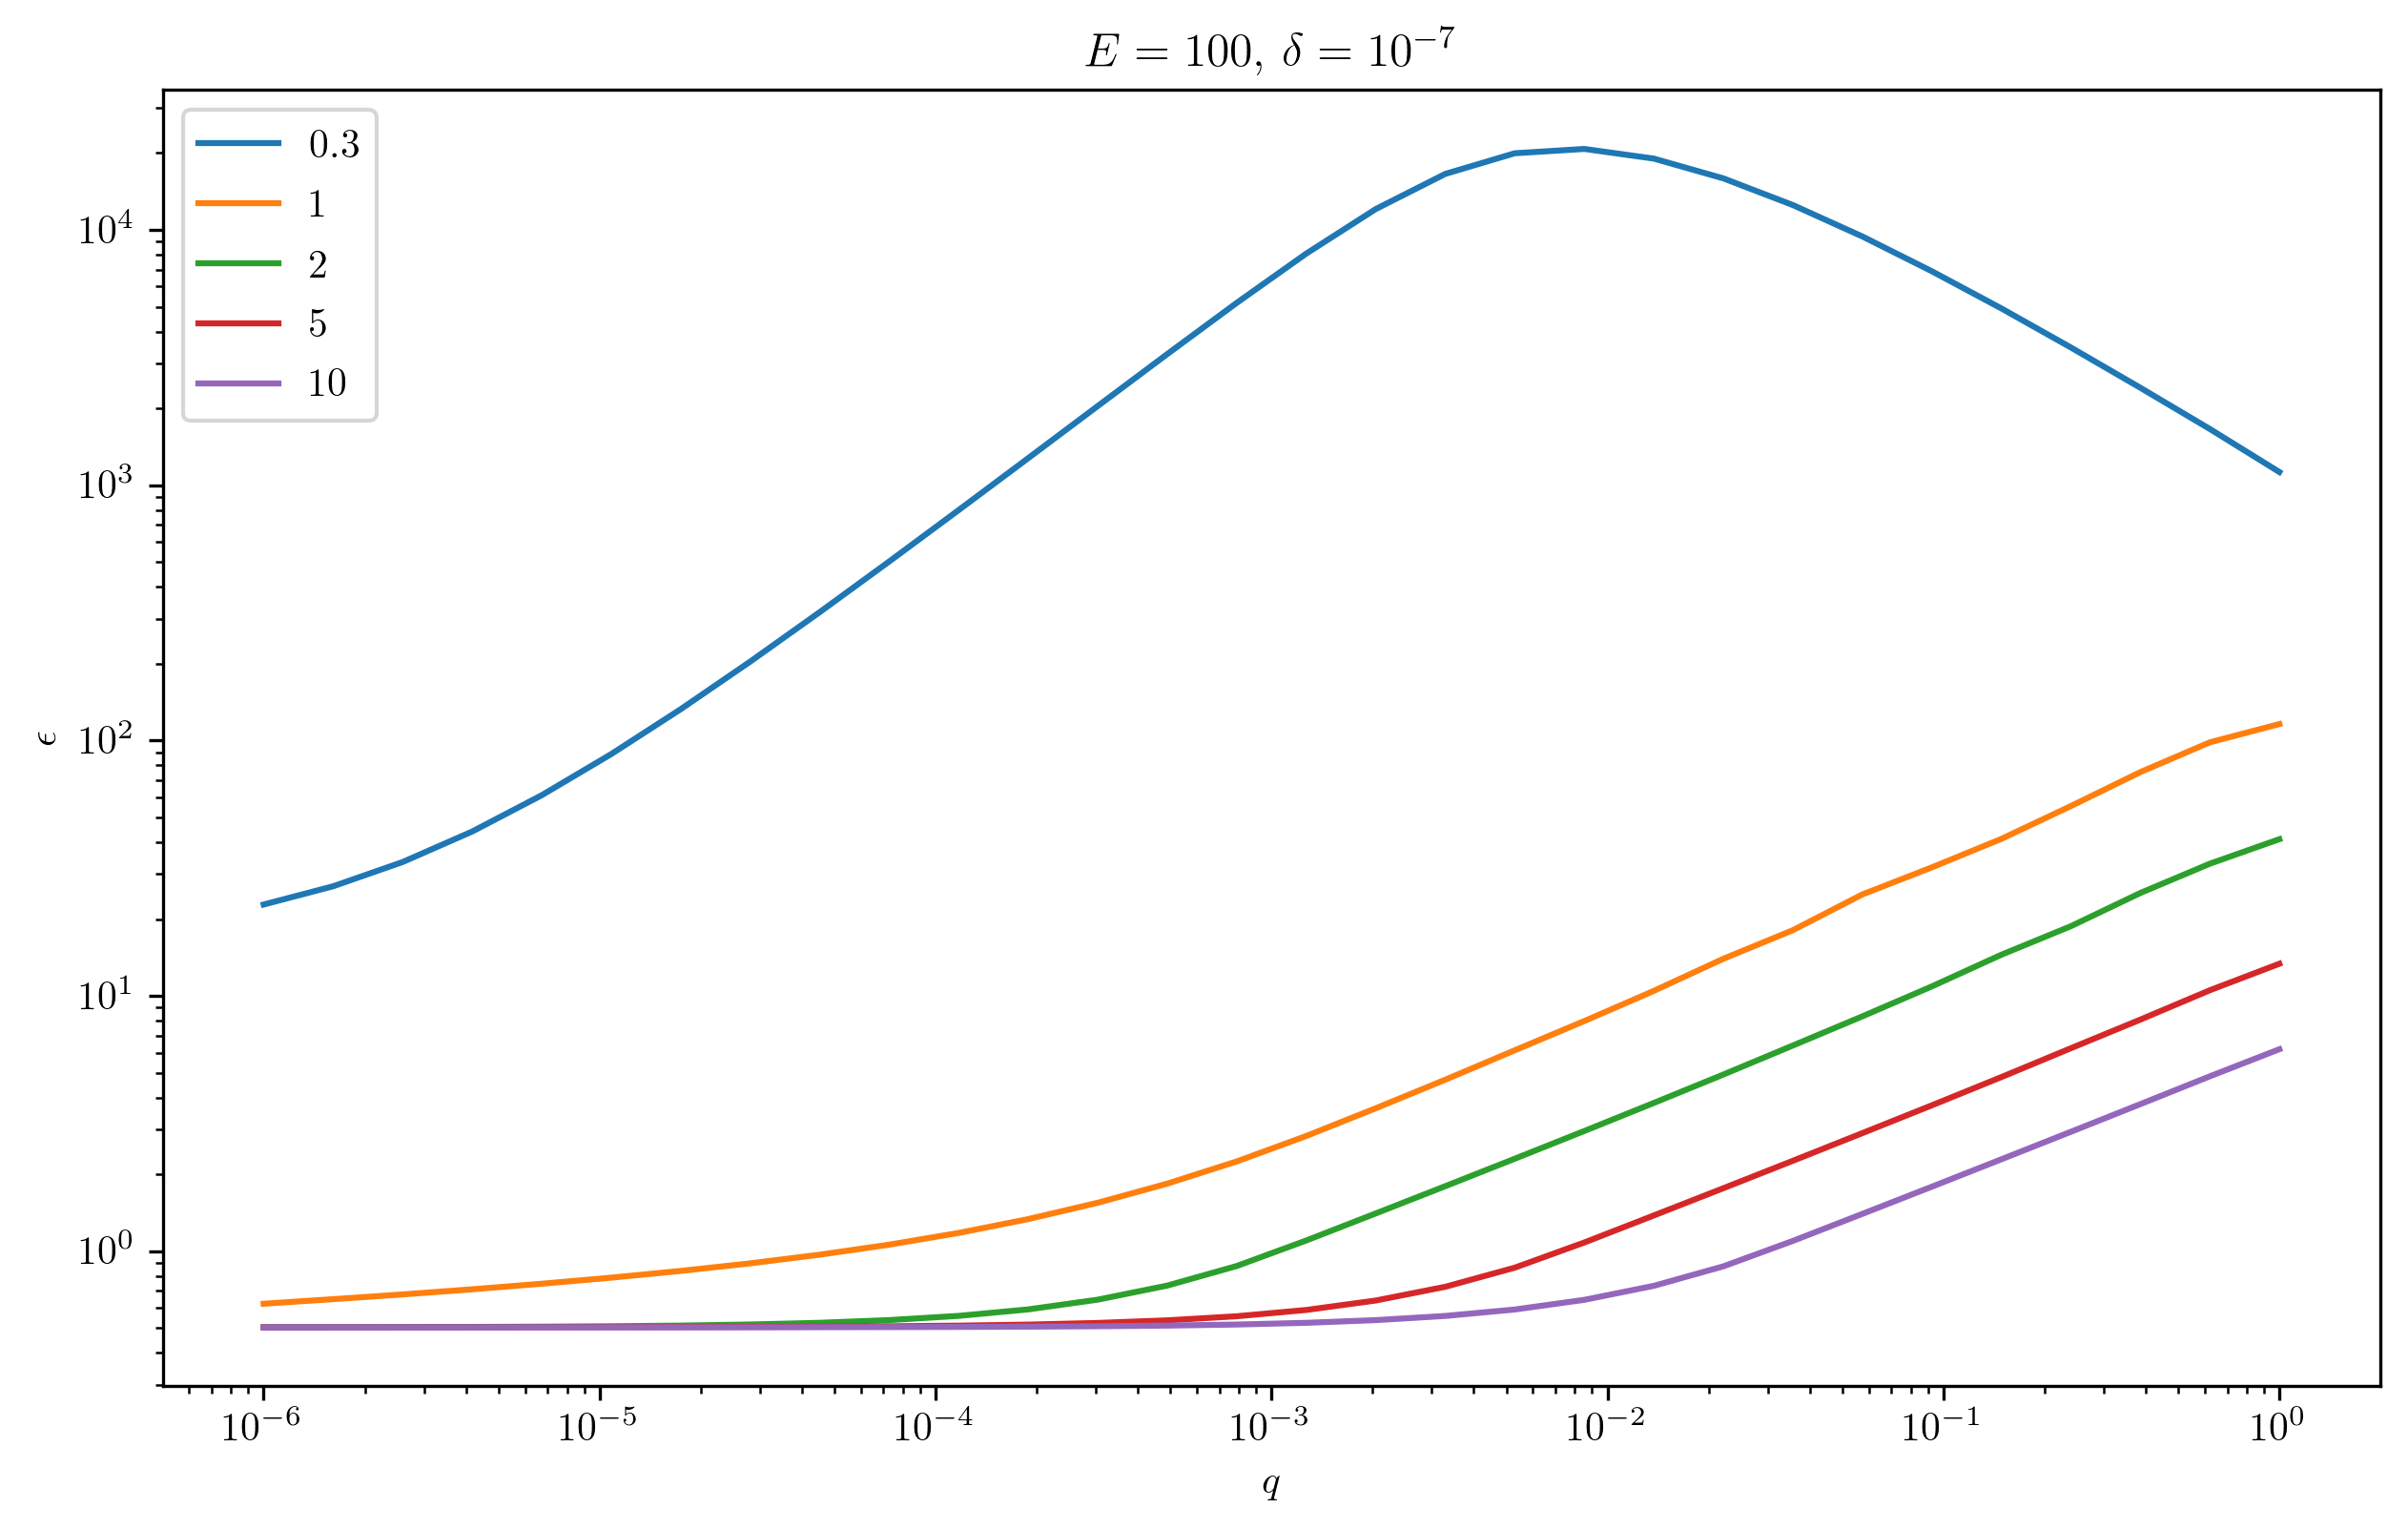

In [34]:
results = []
sigma = [0.3, 1, 2, 5, 10]
q_s = np.logspace(-6, 0, 30)
max_lambda = 32
E = 100

# directly use log moments here as it's the quickest
for sig in sigma:
    eps_vals = []
    for q in q_s:
#         print(f"Calculating for q={q}, sigma={sig}")
        x = []
        eps = []
        N_iter = np.ceil(E * 1/q)
        log_moments = N_iter * generate_log_moments(q, sig, max_lambda)
        privacy = ma.get_privacy_spent(max_lambda, log_moments, None, delta)
        eps, delta_ach = privacy
        eps_vals.append(eps)
    results.append((sig, eps_vals))
    
plt.figure(figsize=(10, 6))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
for sig, eps in results:
    plt.plot(q_s, eps)

ax = plt.gca()
ax.set_xscale("log")
ax.set_yscale("log")
plt.legend(sigma)
plt.xlabel('$q$')
plt.ylabel('$\epsilon$')
plt.title('$E=100$, $\delta=10^{-7}$')
plt.show()

# Can we reason by analogy to give DP guarantees for small values of sigma?

If we were releasing a fixed quantity, $f(\mathcal{D})$, $N$ times with noise scale $\sigma$, is this **precisely** equivalent to releasing $f(\mathcal{D})$ once with noise scale $\sigma / \sqrt{N}$.

### PLD Accountant

In [48]:
eps = get_eps_add_remove_fixed_params(target_delta=1e-4, sigma=10, q=0.9, ncomp=100, nx=1E6, L=50.0)

Add-Remove DP-epsilon after 100 compositions:3.3651624560456943 (delta=0.0001)


In [49]:
eps = get_eps_add_remove_fixed_params(target_delta=1e-4, sigma=1, q=0.9, ncomp=1, nx=1E6, L=50.0)

Add-Remove DP-epsilon after 1 compositions:3.6734883377684975 (delta=0.0001)


In [37]:
q = 1e-2
sig = 1
N = 100
max_lambda = 32
delta = 1e-3

log_moments1 = N * generate_log_moments(q, sig, max_lambda)
log_moments2 = generate_log_moments(q, sig * (N ** -0.5), max_lambda)
eps1, delta, lambda_max1 = ma.moment_accountant._compute_eps(max_lambda, log_moments1, delta)
eps2, delta, lambda_max2 = ma.moment_accountant._compute_eps(max_lambda, log_moments2, delta)
print(f"N times composition: eps={eps1}\n1 time application: eps={eps2}")

N times composition: eps=1.041635614211066
1 time application: eps=97.69741492344377


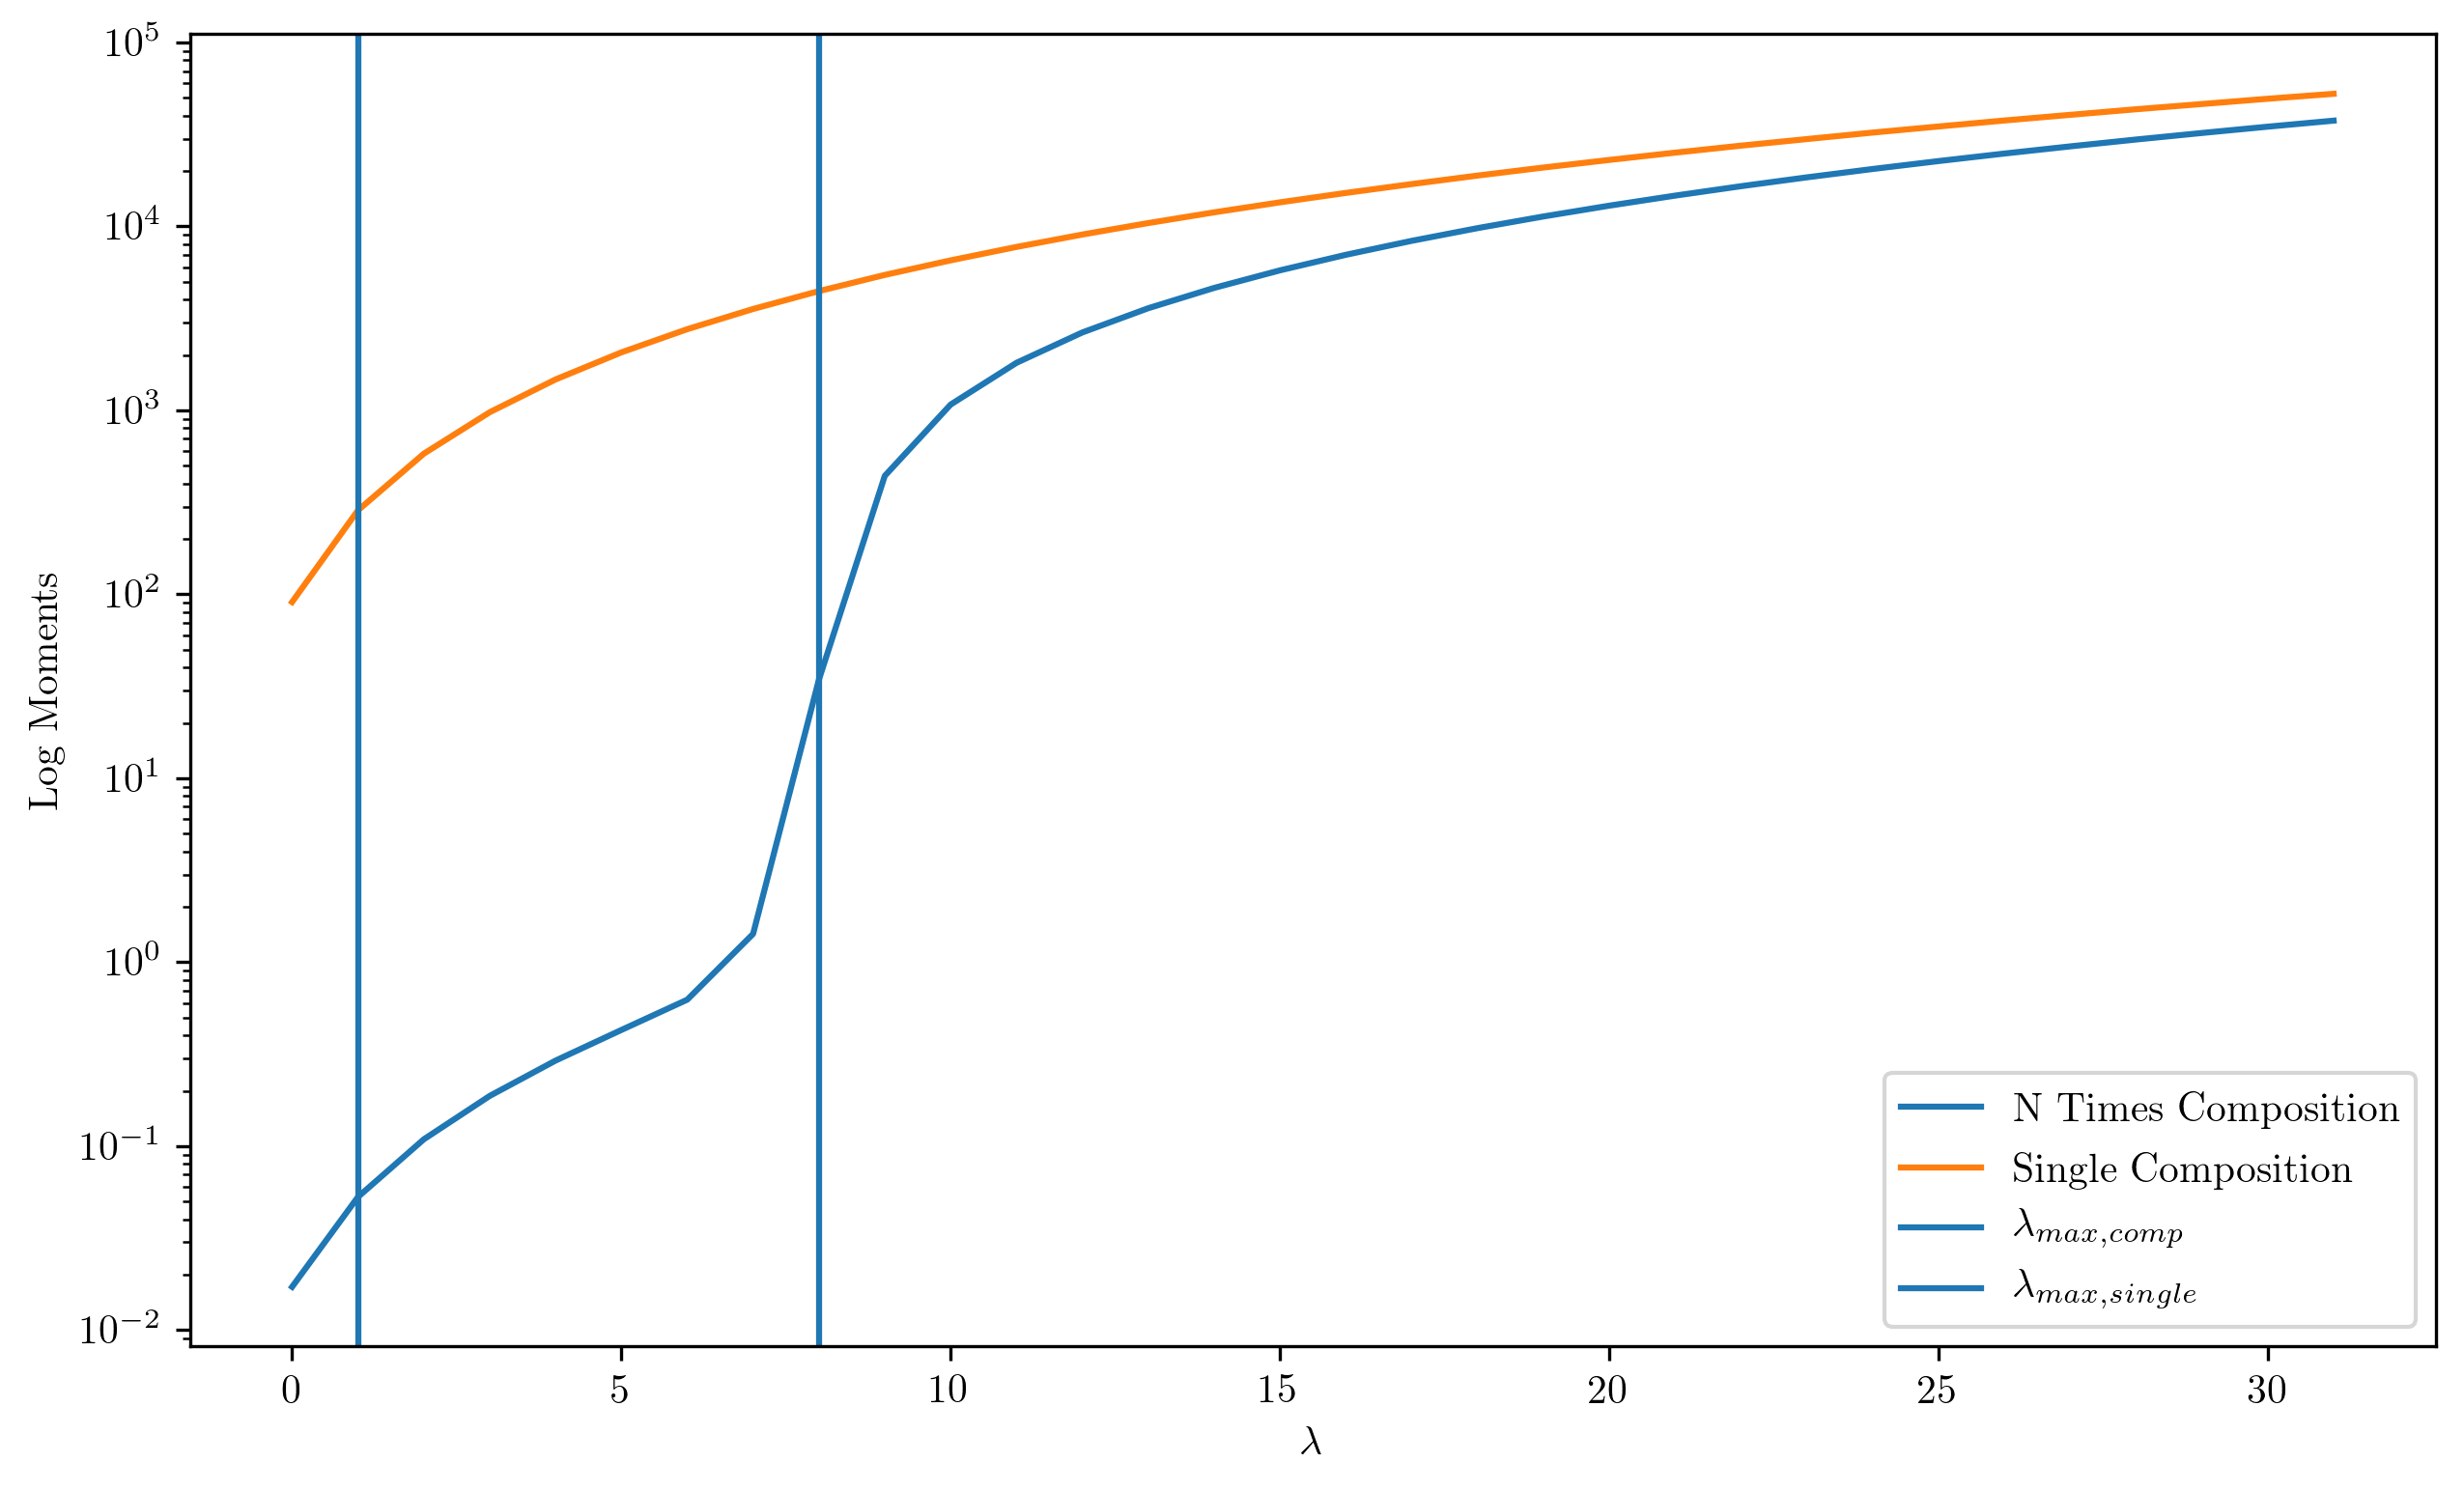

In [40]:
plt.figure(figsize=(10, 6))
ax = plt.gca()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.plot(log_moments1)
plt.plot(log_moments2)
plt.axvline(lambda_max1)
plt.axvline(lambda_max2)
ax.set_yscale("log")
plt.legend(["N Times Composition", "Single Composition", "$\lambda_{max, comp}$", "$\lambda_{max, single}$"])
plt.xlabel("$\lambda$")
plt.ylabel("Log Moments")
plt.show()

## This experiment makes no sense!
I've just realised this - why? Because in one case we subsample $N$ times and in the other case we only subsample once! In the case where $q=1$, this will give exactly the same results!

N times composition: eps=106.90775527898214
1 time application: eps=106.90775529541996


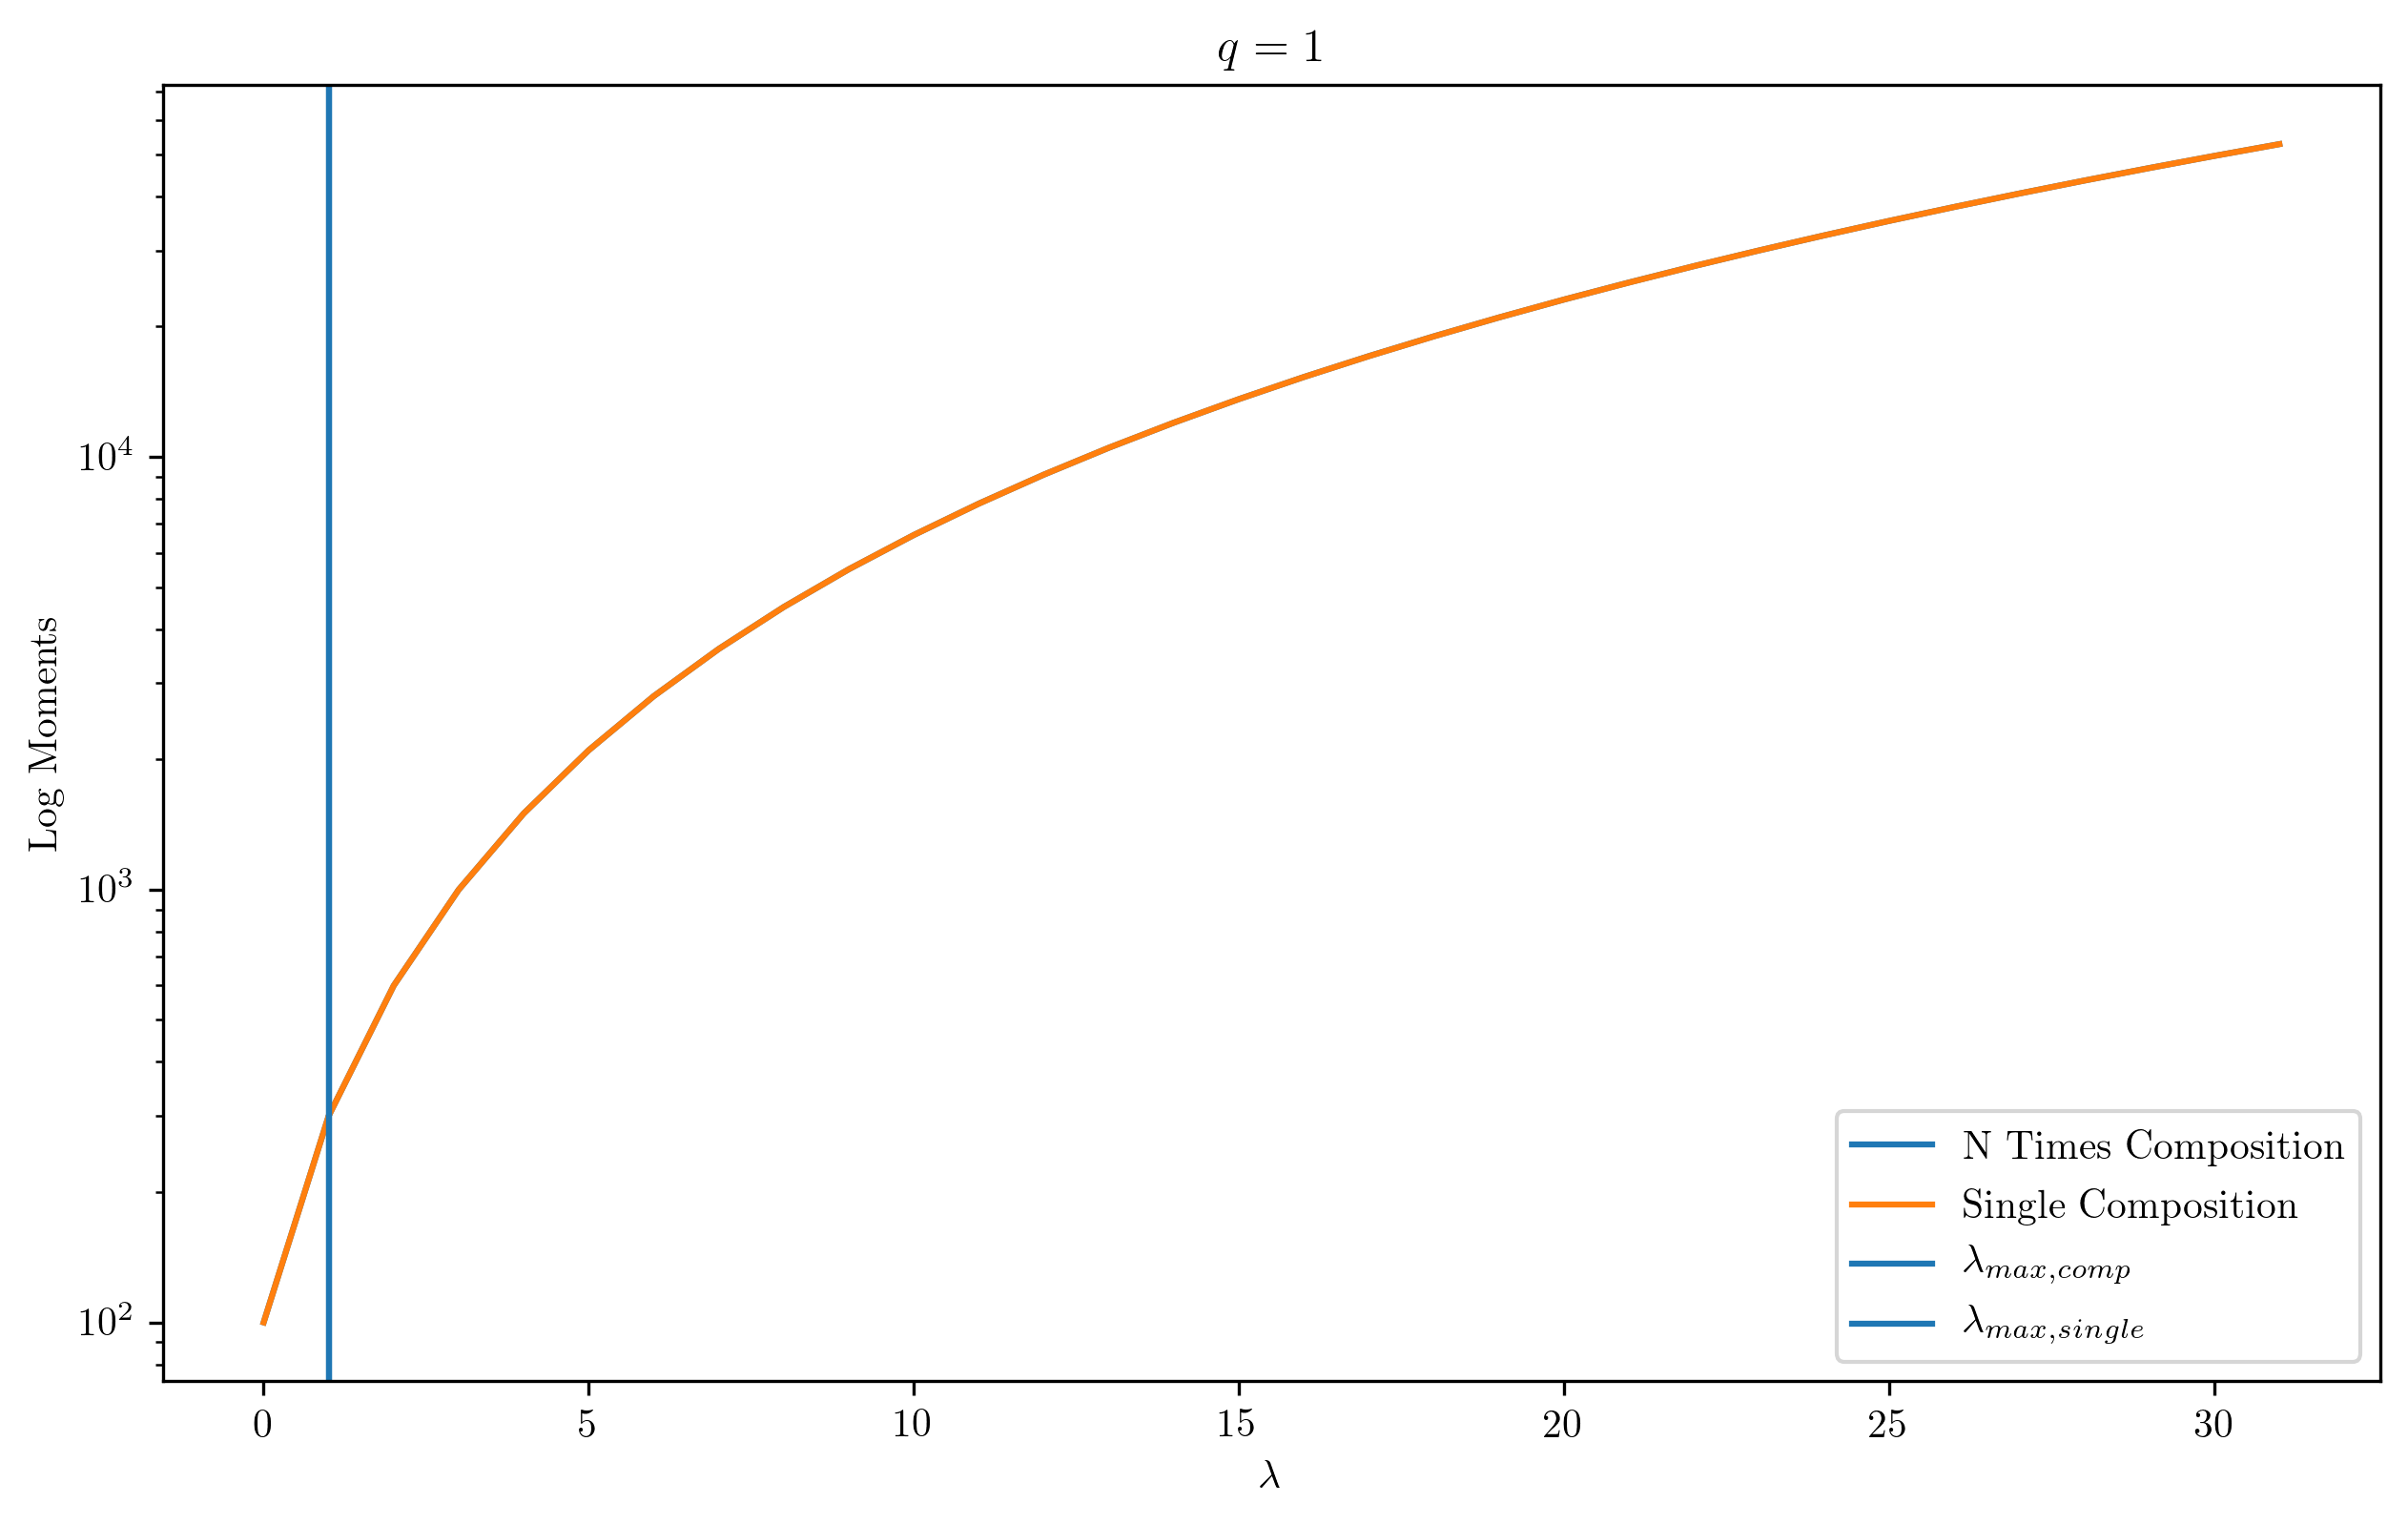

In [51]:
q = 1
sig = 1
N = 100
max_lambda = 32
delta = 1e-3

log_moments1 = N * generate_log_moments(q, sig, max_lambda)
log_moments2 = generate_log_moments(q, sig * (N ** -0.5), max_lambda)
eps1, delta, lambda_max1 = ma.moment_accountant._compute_eps(max_lambda, log_moments1, delta)
eps2, delta, lambda_max2 = ma.moment_accountant._compute_eps(max_lambda, log_moments2, delta)
print(f"N times composition: eps={eps1}\n1 time application: eps={eps2}")
plt.figure(figsize=(10, 6))
ax = plt.gca()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.plot(log_moments1)
plt.plot(log_moments2)
plt.axvline(lambda_max1)
plt.axvline(lambda_max2)
ax.set_yscale("log")
plt.legend(["N Times Composition", "Single Composition", "$\lambda_{max, comp}$", "$\lambda_{max, single}$"])
plt.xlabel("$\lambda$")
plt.ylabel("Log Moments")
plt.title("$q=1$")
plt.show()

## Original Graph - remade
But now instead of fixing the number of epochs, fix the number of update steps to $N=10000$.

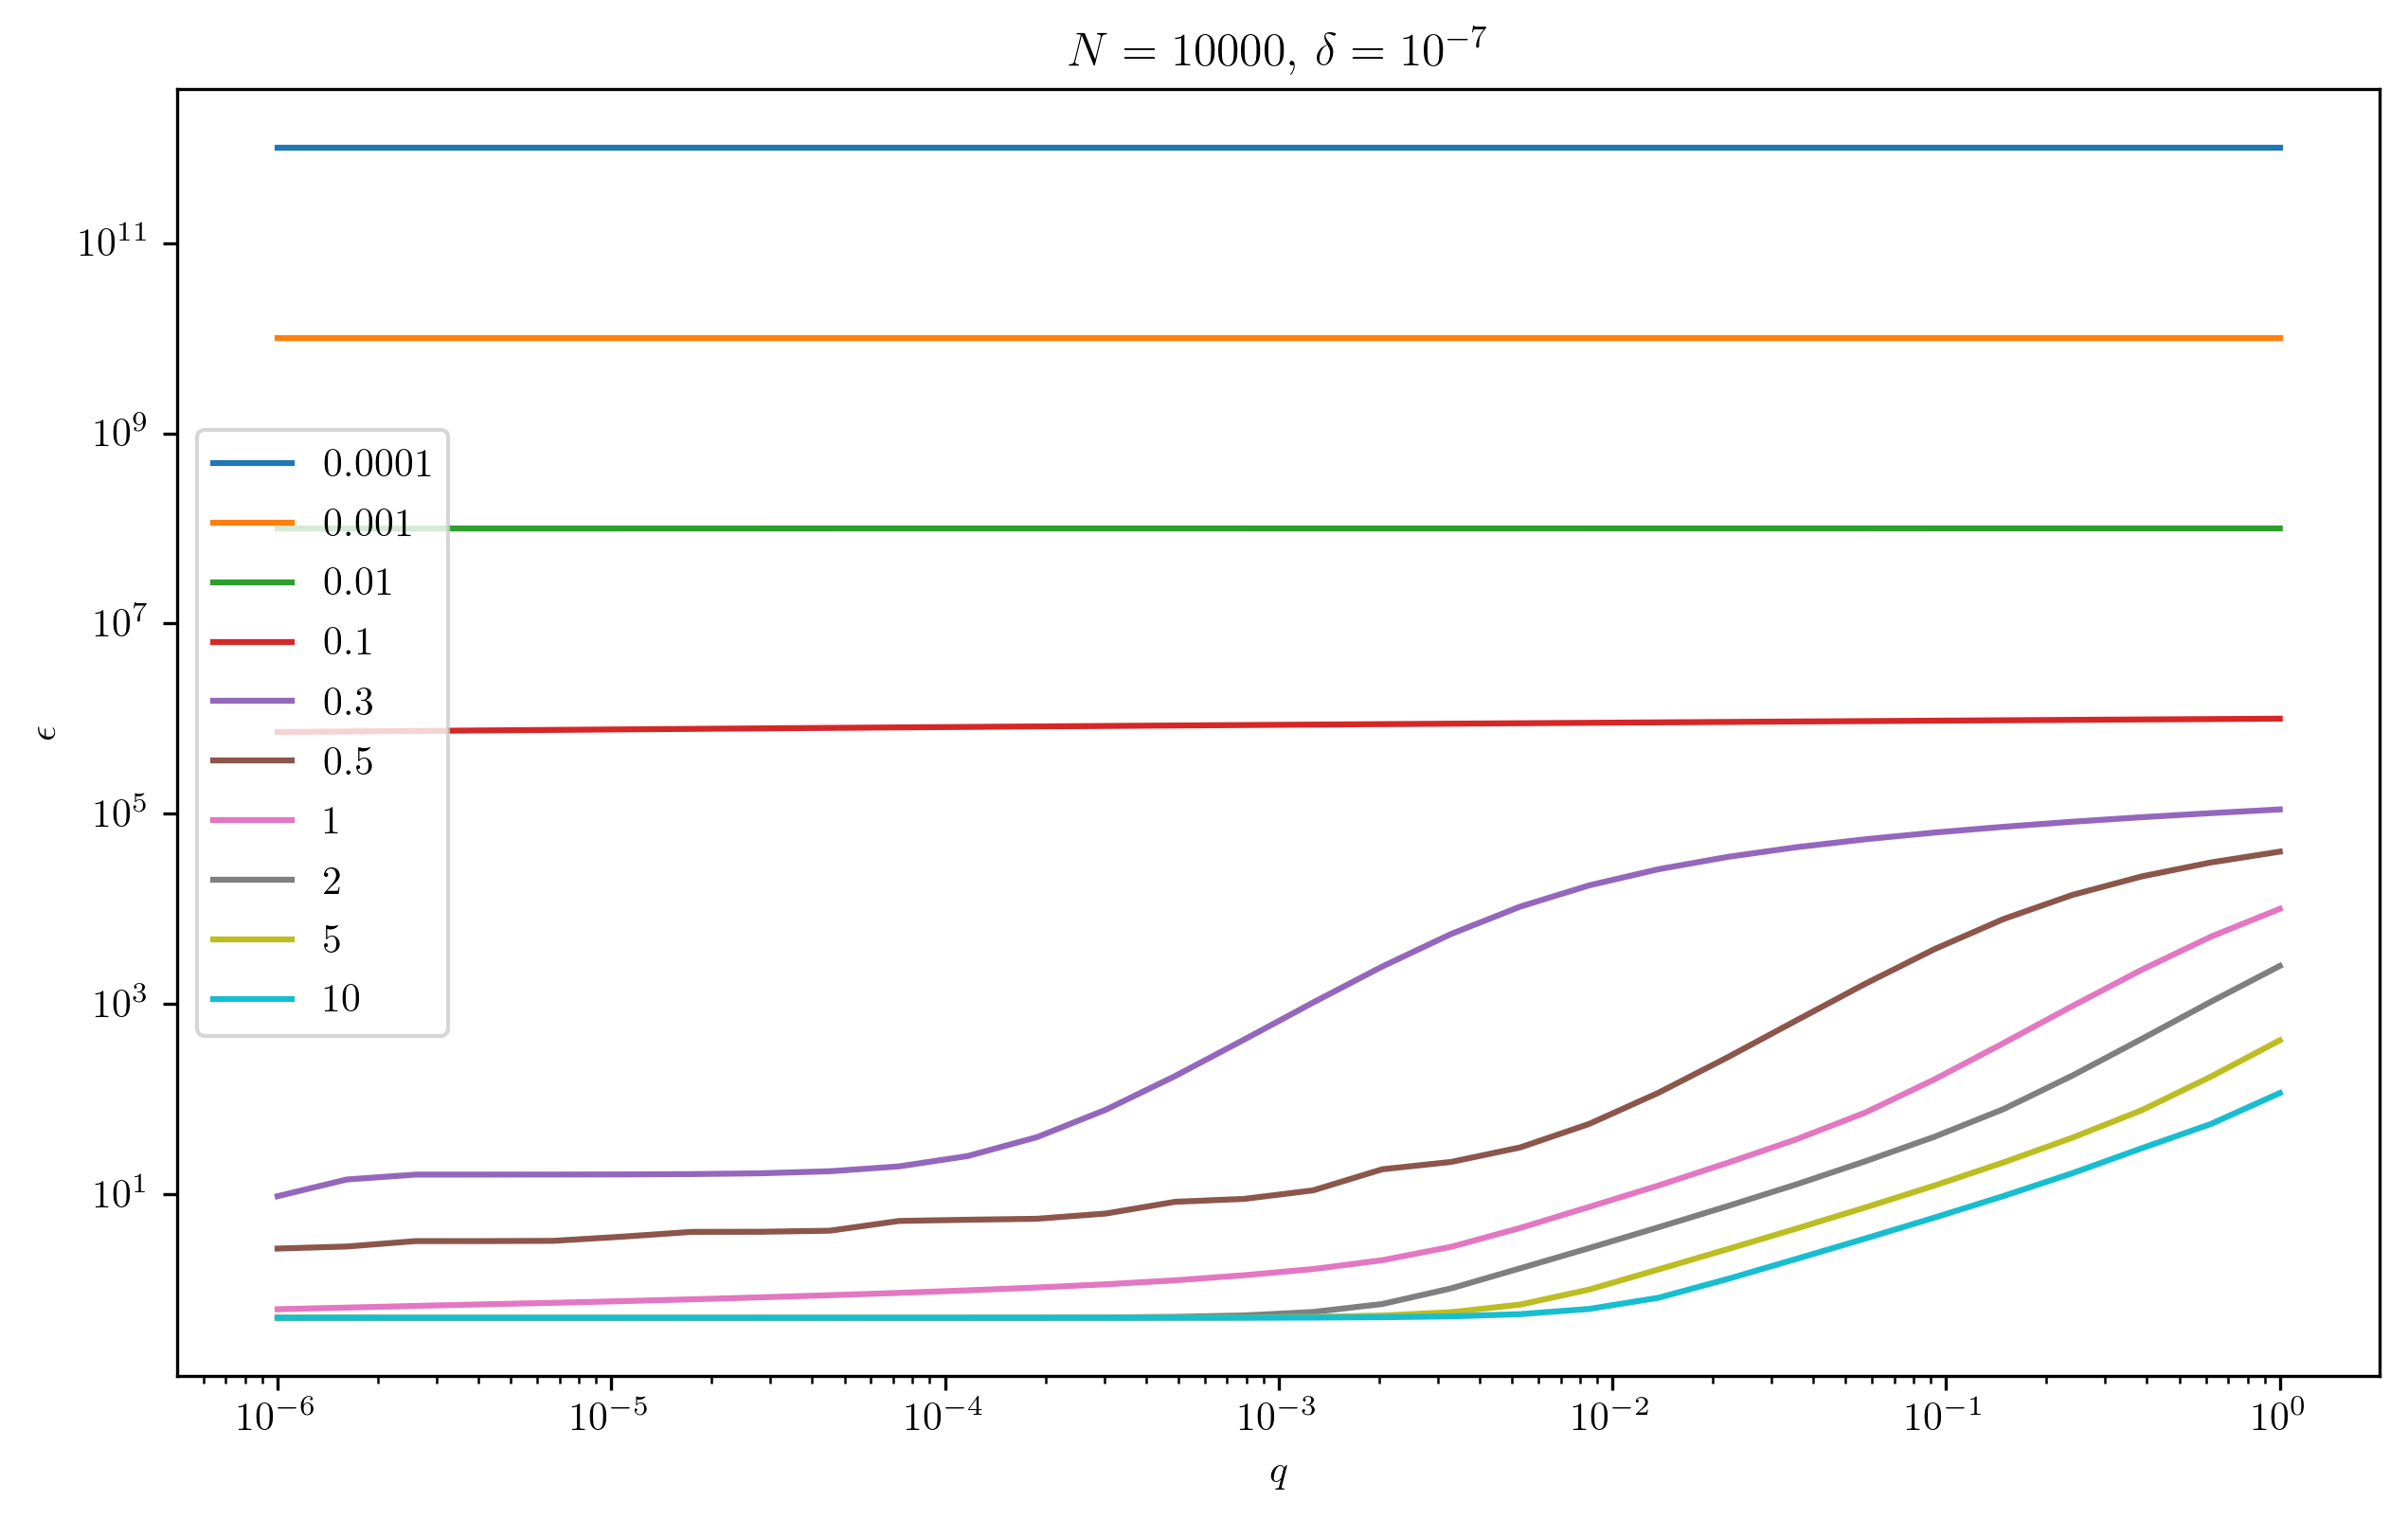

In [55]:
# fix quite a small signal to noise ratio
sigma = [1e-4, 1e-3, 1e-2, 0.1, 0.3, 0.5, 1, 2, 5, 10]
q_s = np.logspace(-6, 0, 30)

results = []

E = 100
delta = 1e-7
max_lambda = 32
N_iter = 10000

# directly use log moments here as it's the quickest
for sig in sigma:
    eps_vals = []
    for q in q_s:
#         print(f"Calculating for q={q}, sigma={sig}")
        x = []
        eps = []
        log_moments = N_iter * generate_log_moments(q, sig, max_lambda)
        privacy = ma.get_privacy_spent(max_lambda, log_moments, None, delta)
#         privacy = get_eps_add_remove_fixed_params(target_delta=delta, sigma=sig, q=q, ncomp=N_iter, nx=2E6 L=100.0)
        eps, delta_ach = privacy
        eps_vals.append(eps)
    results.append((sig, eps_vals))

plt.figure(figsize=(10, 6))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
for sig, eps in results:
    plt.plot(q_s, eps)

ax = plt.gca()
ax.set_xscale("log")
ax.set_yscale("log")
plt.legend(sigma)
plt.xlabel('$q$')
plt.ylabel('$\epsilon$')
plt.title('$N=10000$, $\delta=10^{-7}$')
plt.show()

# Moments Accountant
## Is the problem the lambdas that we are considering?

In [16]:
import math
import mpmath as mp
import numpy as np

float_type = np.float32
int_type = np.int32


def to_np_float_64(v):
    if math.isnan(v) or math.isinf(v):
        return np.inf
    else:
        return np.float64(v)


def pdf_gauss(x, sigma, mean):
    return mp.mpf(1.) / mp.sqrt(mp.mpf("2.") * sigma ** 2 * mp.pi) * mp.exp(
        - (x - mean) ** 2 / (mp.mpf("2.") * sigma ** 2))


def get_I1_I2_lambda(lambda_val, pdf1, pdf2):
    I1_func = lambda x: pdf1(x) * (pdf1(x) / pdf2(x)) ** lambda_val
    I2_func = lambda x: pdf2(x) * (pdf2(x) / pdf1(x)) ** lambda_val
    return I1_func, I2_func


def integral_inf_mp(fn):
    integral, _ = mp.quad(fn, [-mp.inf, mp.inf], error=True)
    return integral


def custom_generate_log_moments(q, noise_scale, min_lambda, max_lambda, N_lambdas):
    # these moments are a function of q, noise_scale and max_lambda
    # generate pdfs which are to be integrated numerically
    pdf1 = lambda x: pdf_gauss(x, noise_scale, mp.mpf(0))
    pdf2 = lambda x: (1 - q) * pdf_gauss(x, noise_scale, mp.mpf(0)) + \
                     q * pdf_gauss(x, noise_scale, mp.mpf(1))
    
    lambda_vals = np.linspace(min_lambda, max_lambda, N_lambdas)
    # placeholder for alpha_M(lambda) for each iteration
    alpha_M_lambda = np.zeros(len(lambda_vals))
    
    
    for ind, lambda_val in enumerate(lambda_vals):
        # it isn't defined which dataset is D and which is D' - thus consider both and take the maximum
        I1_func, I2_func = get_I1_I2_lambda(lambda_val, pdf1, pdf2)
        I1_val = integral_inf_mp(I1_func)
        I2_val = integral_inf_mp(I2_func)

        if I1_val > I2_val:
            alpha_M_lambda[ind] = to_np_float_64(mp.log(I1_val))
        else:
            alpha_M_lambda[ind] = to_np_float_64(mp.log(I2_val))

    return alpha_M_lambda, lambda_vals

def custom_compute_eps(lambda_vals, total_log_moments, target_delta):
    """ Compute the epsilon upper bound for a fixed delta

    :param max_lambda: The maximum moment considered
    :param total_log_moments: The total of each moment accumulated
    :param target_delta: The target delta
    :return: epsilon bound, delta bound, order of moment responsible for the bound
    """
    eps_bounds = np.zeros(len(lambda_vals))
    for ind, lambda_i in enumerate(lambda_vals):
        lambda_i_eps_bound = (1.0 / lambda_i) * (total_log_moments[ind] - np.log(target_delta))
        eps_bounds[ind] = lambda_i_eps_bound

    max_index = np.argmin(eps_bounds)
    return eps_bounds[max_index], target_delta, lambda_vals[max_index]


In [17]:
sig = 0.01
q_s = np.logspace(-6, 0, 5)
target_delta = 1e-7
E = 100
max_lambda = 64
min_lambda = 0.01
N_lambdas = 128
all_log_moments = []
all_lambda_vals = []
all_best_lambdas = []
eps_vals = []

for q in q_s:
    N_iter = np.ceil(E * 1/q)
    log_moments, lambda_vals = custom_generate_log_moments(q, sig, min_lambda, max_lambda, N_lambdas)
    total_log_moments = N_iter * log_moments
    eps, _, best_lambda = custom_compute_eps(lambda_vals, total_log_moments, target_delta)
    all_log_moments.append(log_moments)
    all_best_lambdas.append(best_lambda)
    all_lambda_vals.append(lambda_vals)
    eps_vals.append(eps)

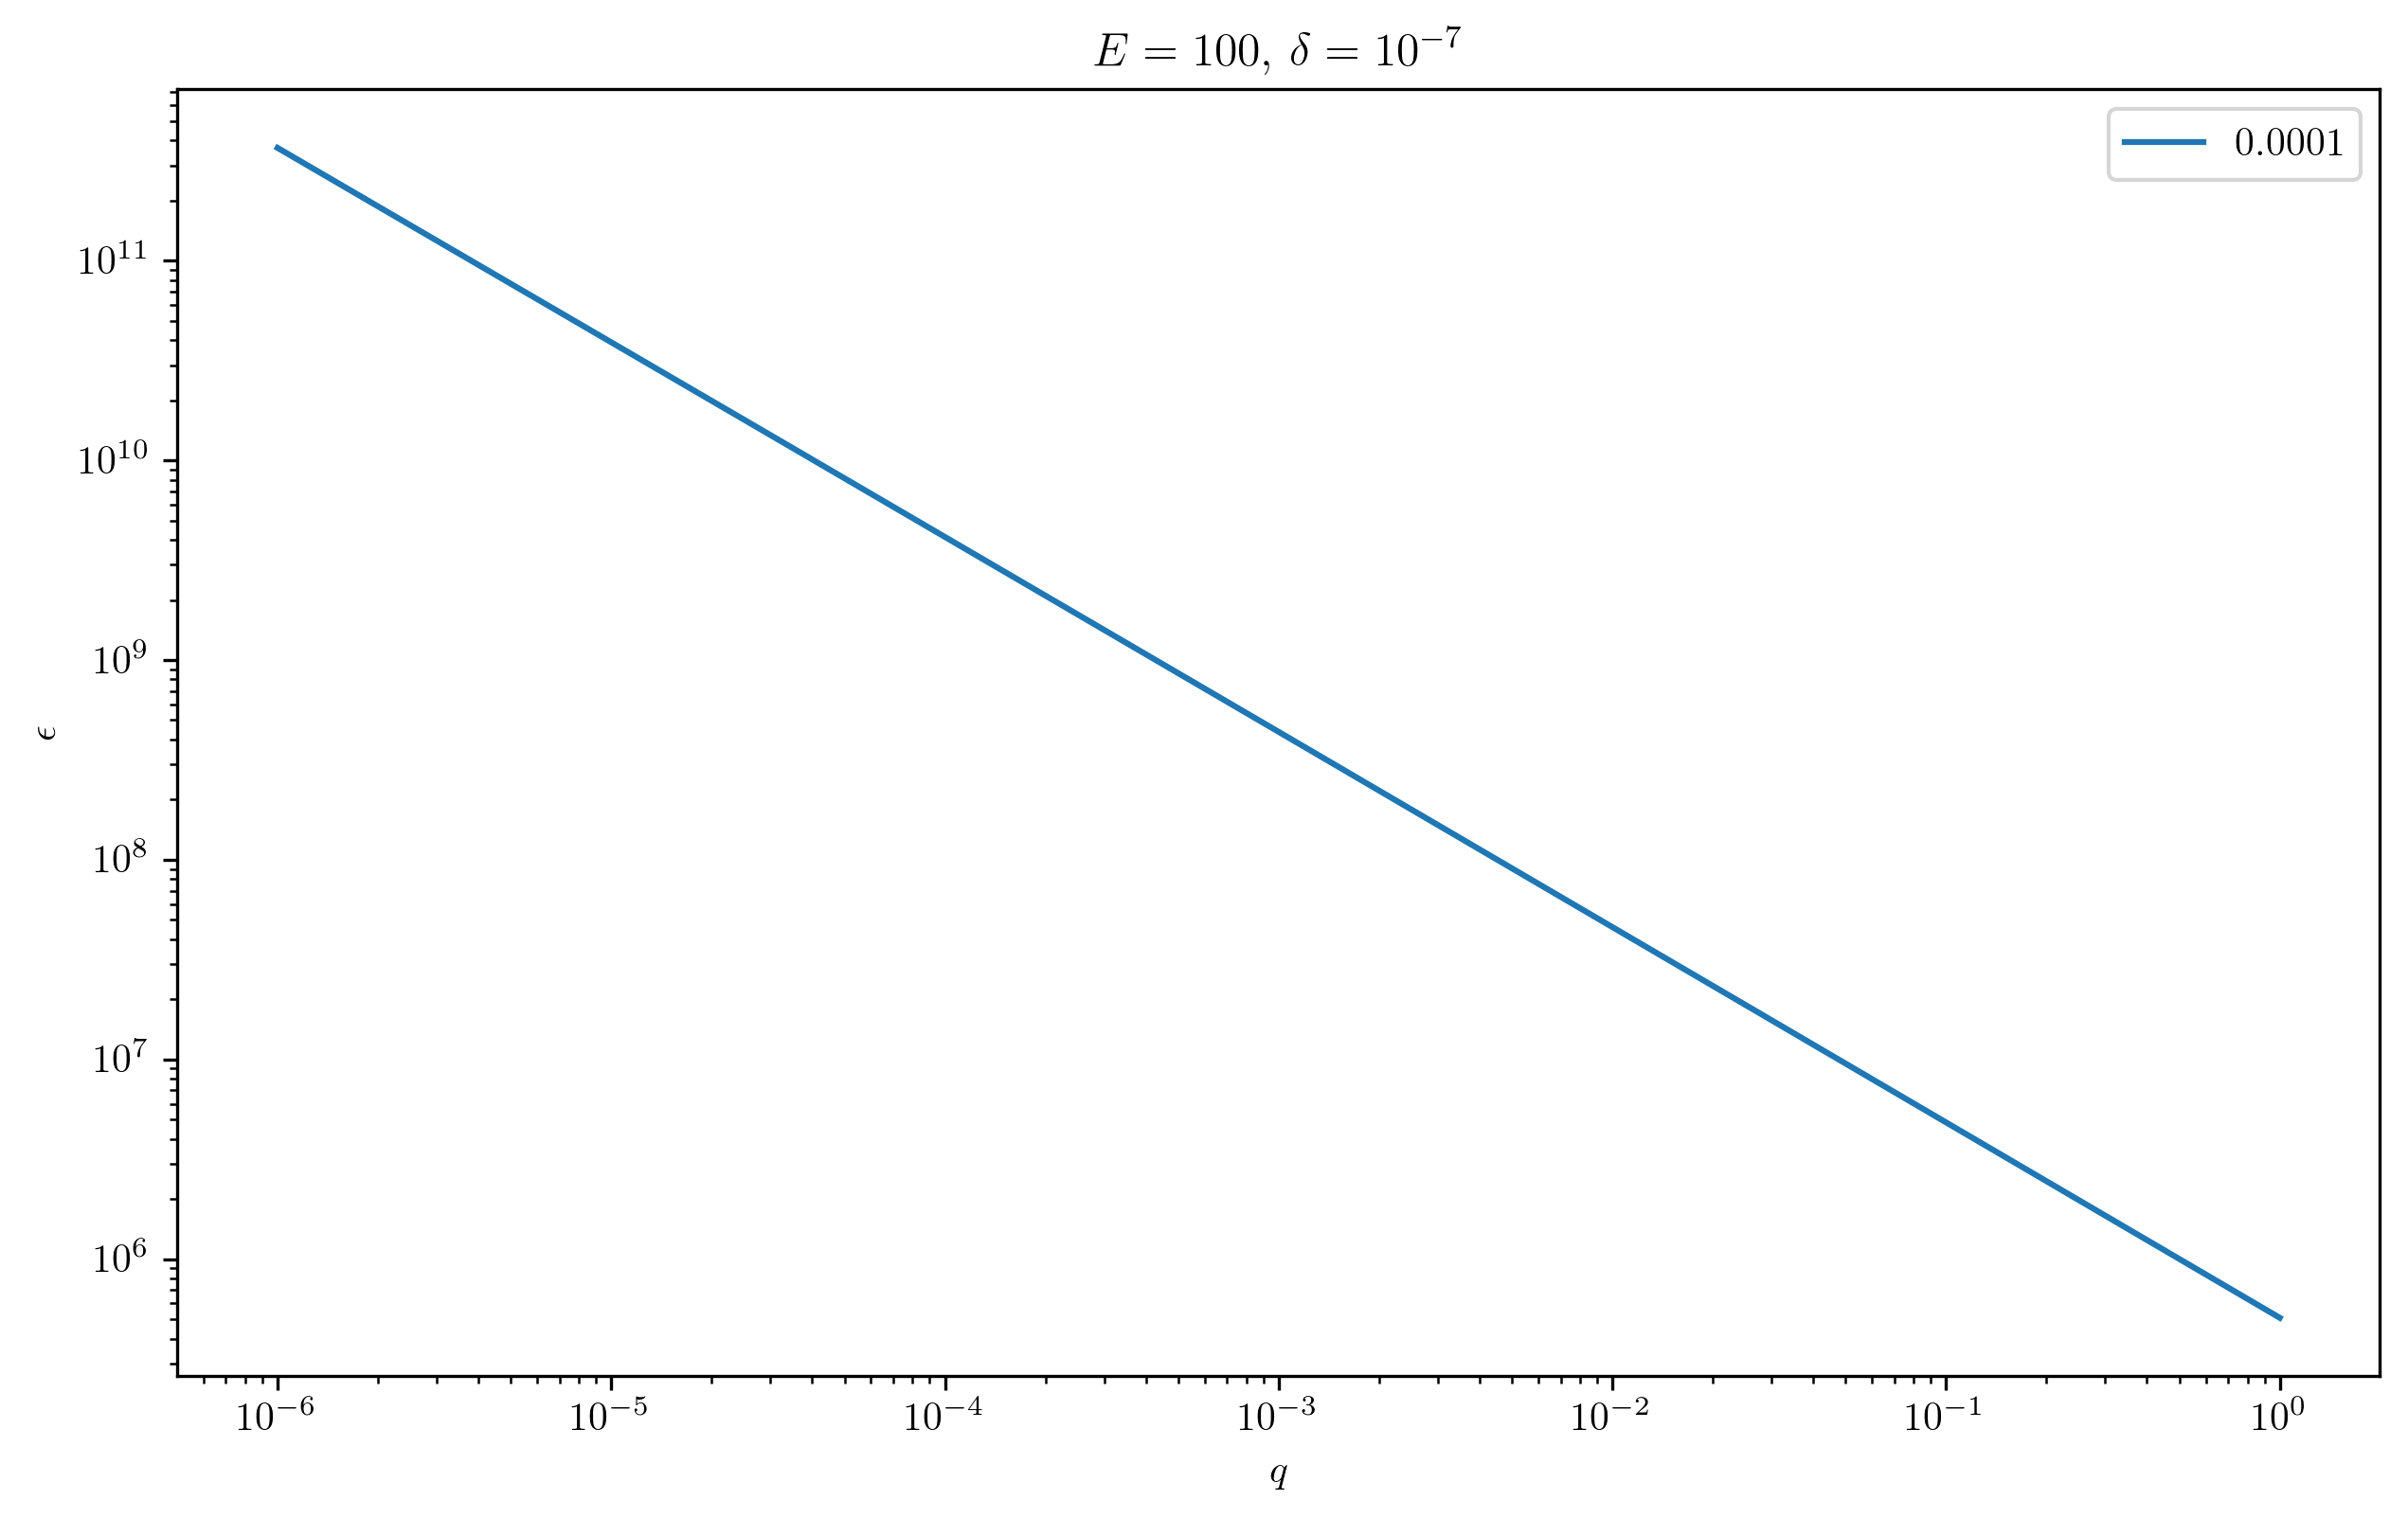

In [20]:
plt.figure(figsize=(10, 6))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.plot(q_s, eps_vals)

ax = plt.gca()
ax.set_xscale("log")
ax.set_yscale("log")
plt.legend(sigma)
plt.xlabel('$q$')
plt.ylabel('$\epsilon$')
plt.title('$E=100$, $\delta=10^{-7}$')
plt.show()    

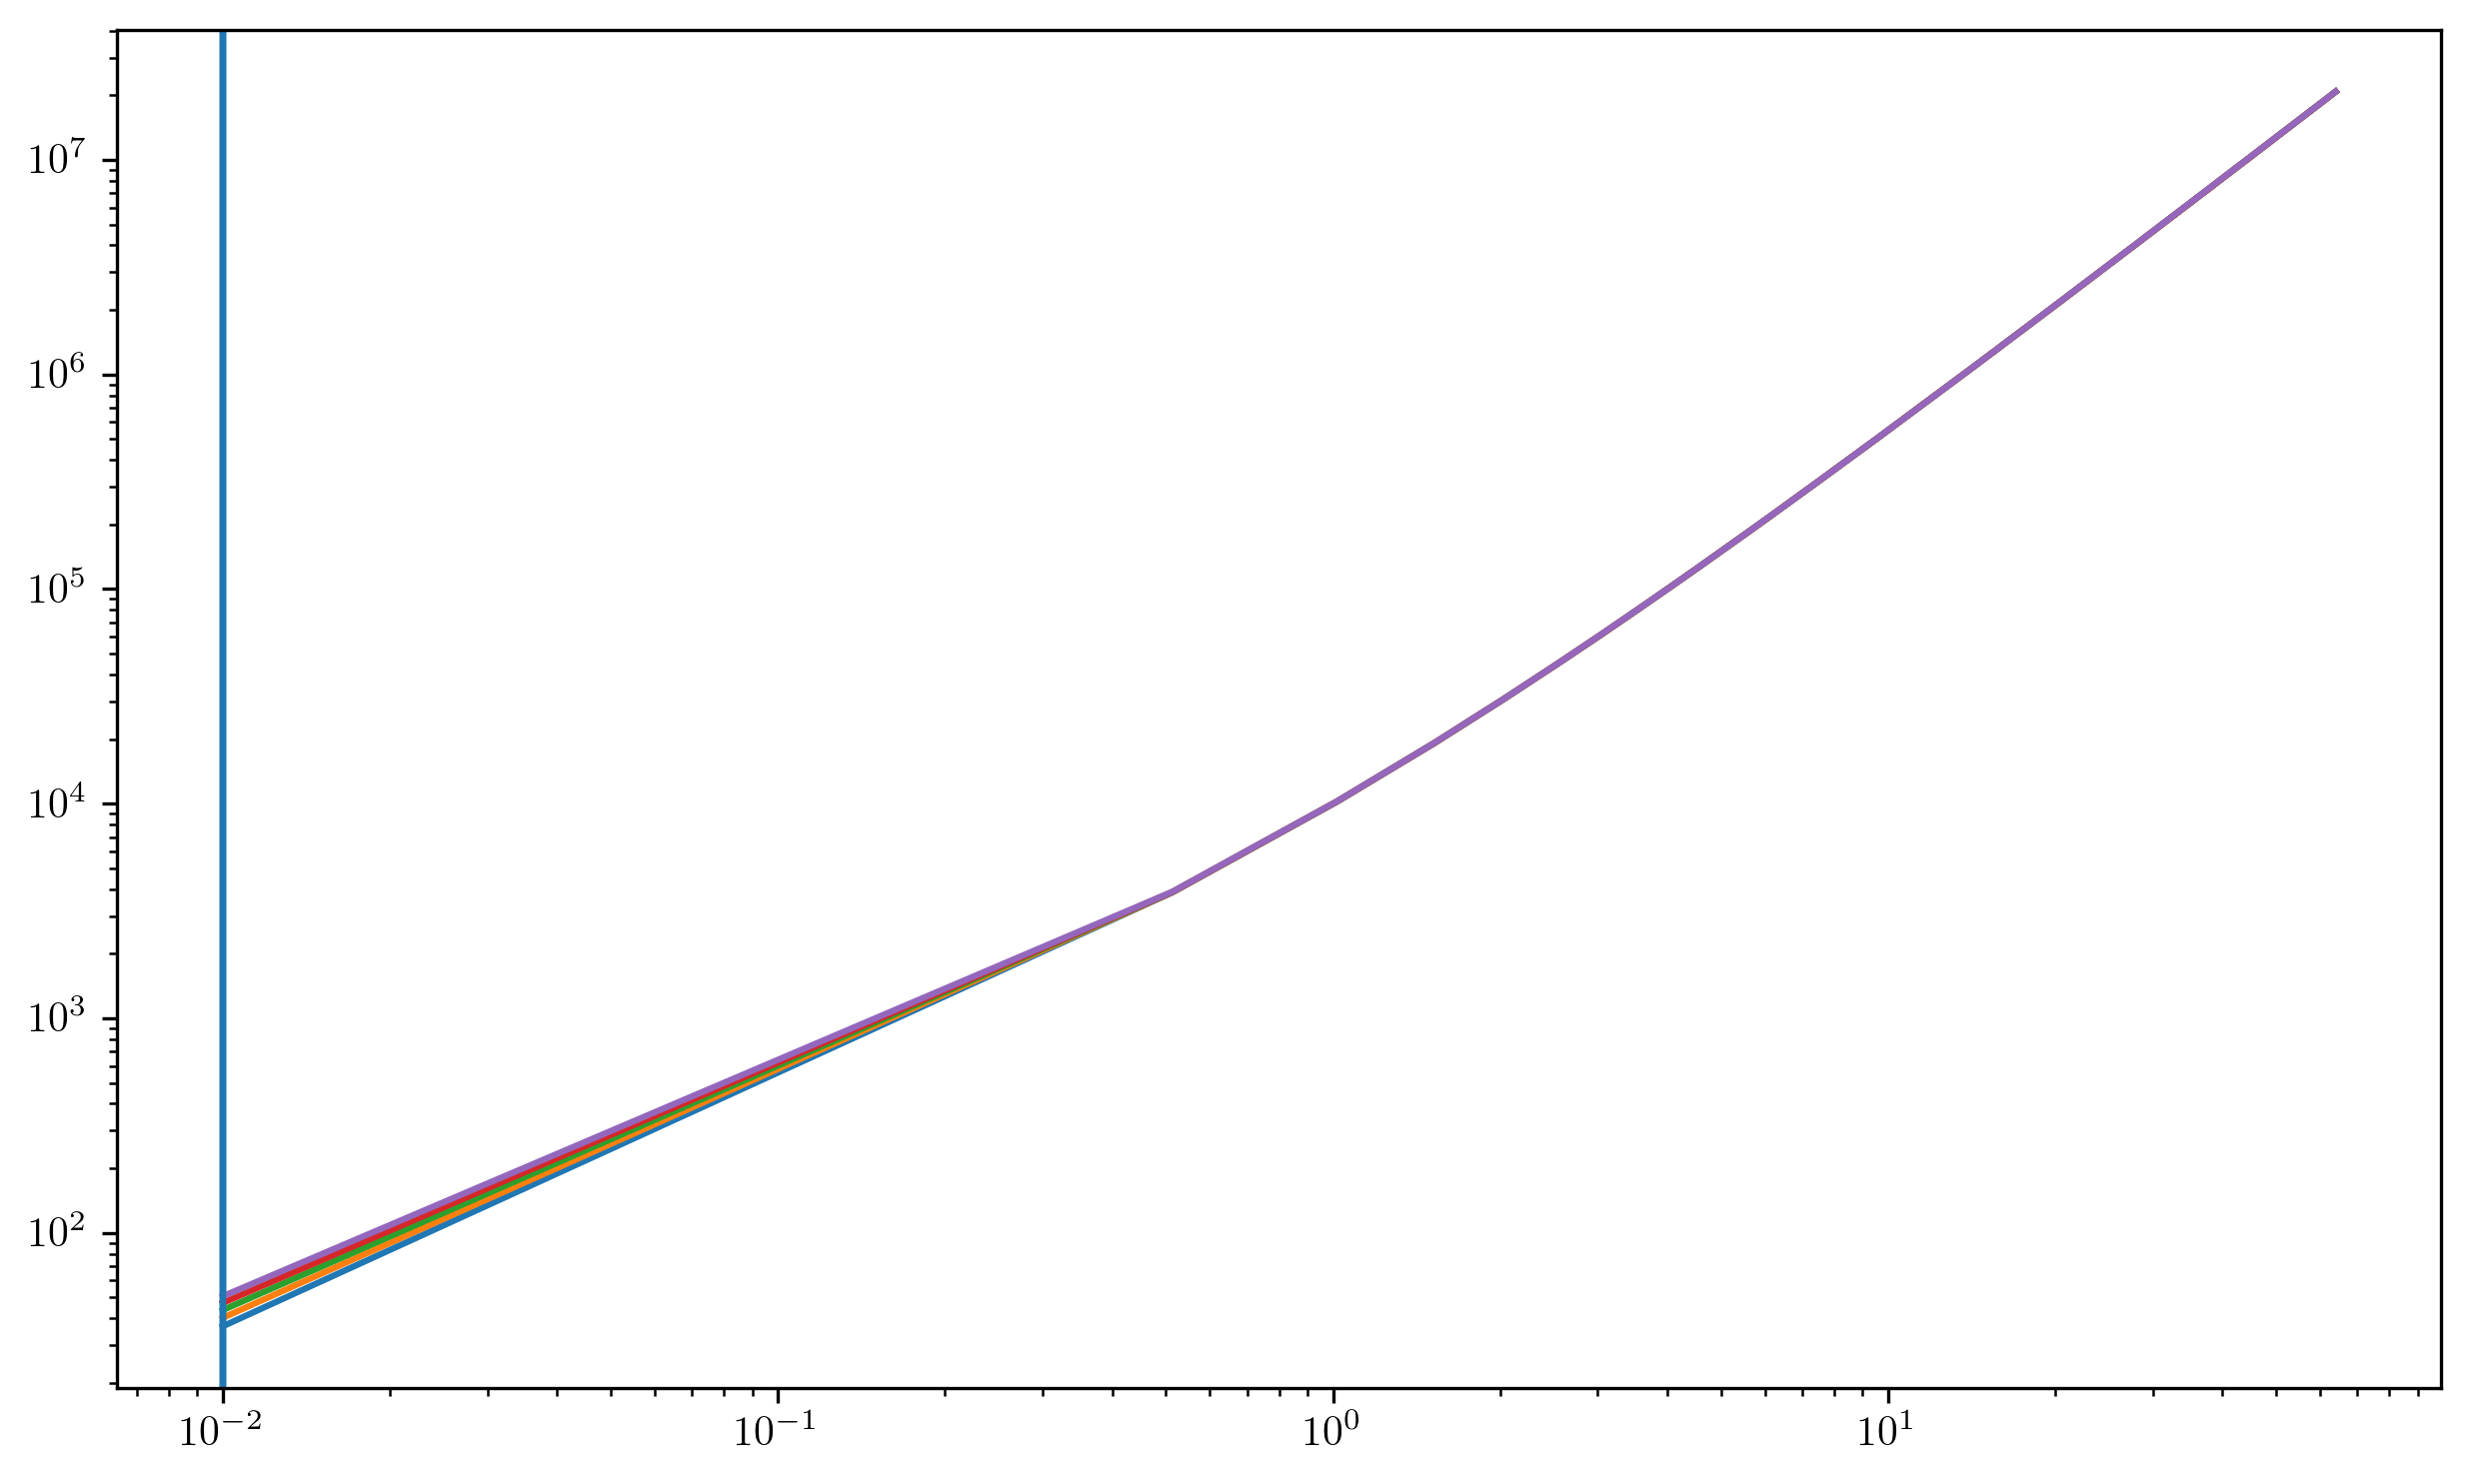

In [22]:
plt.figure(figsize=(10, 6))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
ax = plt.gca()
ax.set_xscale("log")
ax.set_yscale("log")

for log_moments, lambda_vals, best_lambda in zip(all_log_moments, all_lambda_vals, all_best_lambdas):
    plt.plot(lambda_vals, log_moments)
    plt.axvline(best_lambda)

plt.show()

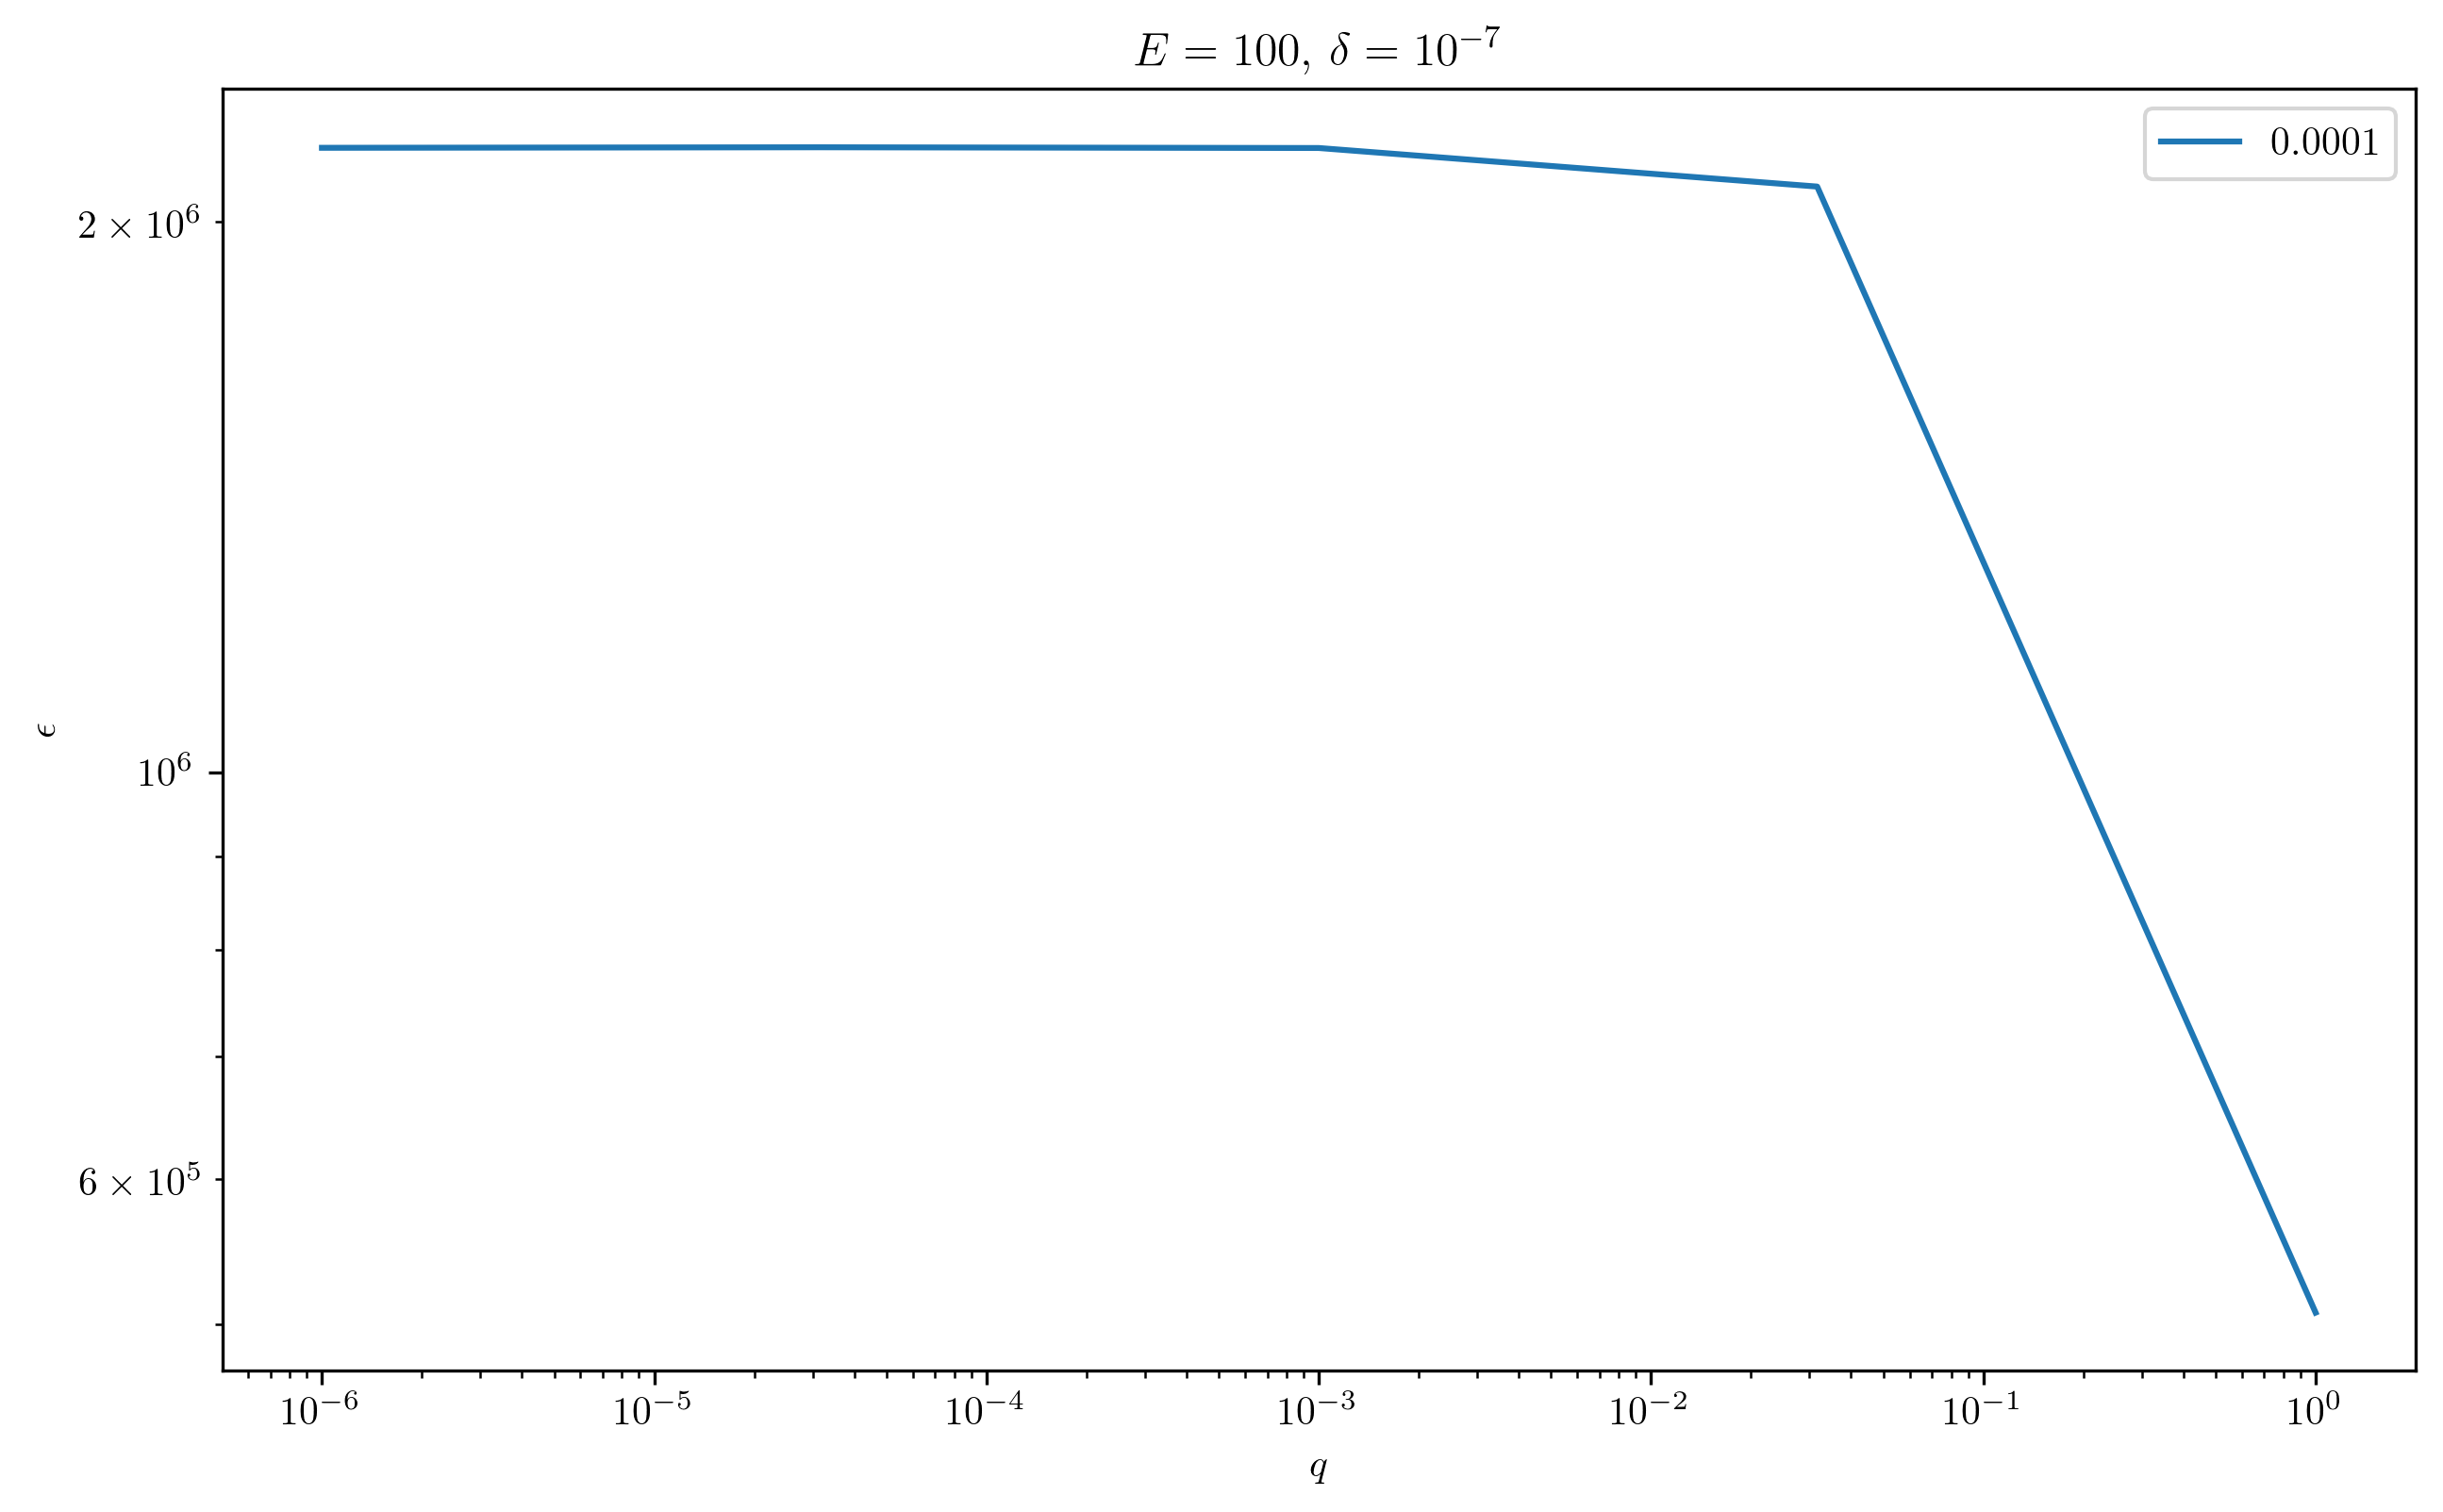

In [50]:
def custom_generate_log_moments_logspace(q, noise_scale, min_lambda, max_lambda, N_lambdas):
    # these moments are a function of q, noise_scale and max_lambda
    # generate pdfs which are to be integrated numerically
    pdf1 = lambda x: pdf_gauss(x, noise_scale, mp.mpf(0))
    pdf2 = lambda x: (1 - q) * pdf_gauss(x, noise_scale, mp.mpf(0)) + \
                     q * pdf_gauss(x, noise_scale, mp.mpf(1))
    
    lambda_vals = np.logspace(min_lambda, max_lambda, N_lambdas)
    # placeholder for alpha_M(lambda) for each iteration
    alpha_M_lambda = np.zeros(len(lambda_vals))
    
    
    for ind, lambda_val in enumerate(lambda_vals):
        # it isn't defined which dataset is D and which is D' - thus consider both and take the maximum
        I1_func, I2_func = get_I1_I2_lambda(lambda_val, pdf1, pdf2)
        I1_val = integral_inf_mp(I1_func)
        I2_val = integral_inf_mp(I2_func)

        if I1_val > I2_val:
            alpha_M_lambda[ind] = to_np_float_64(mp.log(I1_val))
        else:
            alpha_M_lambda[ind] = to_np_float_64(mp.log(I2_val))

    return alpha_M_lambda, lambda_vals

sig = 0.01
q_s = np.logspace(-6, 0, 5)
target_delta = 1e-7
E = 100
max_lambda = 1
min_lambda = -6
N_lambdas = 256
all_log_moments = []
all_lambda_vals = []
all_best_lambdas = []
eps_vals = []

for q in q_s:
    N_iter = np.ceil(E * 1/q)
    log_moments, lambda_vals = custom_generate_log_moments_logspace(q, sig, min_lambda, max_lambda, N_lambdas)
    total_log_moments = N_iter * log_moments
    eps, _, best_lambda = custom_compute_eps(lambda_vals, total_log_moments, target_delta)
    all_log_moments.append(log_moments)
    all_best_lambdas.append(best_lambda)
    all_lambda_vals.append(lambda_vals)
    eps_vals.append(eps)

plt.figure(figsize=(10, 6))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.plot(q_s, eps_vals)

ax = plt.gca()
ax.set_xscale("log")
ax.set_yscale("log")
plt.legend(sigma)
plt.xlabel('$q$')
plt.ylabel('$\epsilon$')
plt.title('$E=100$, $\delta=10^{-7}$')
plt.show()    

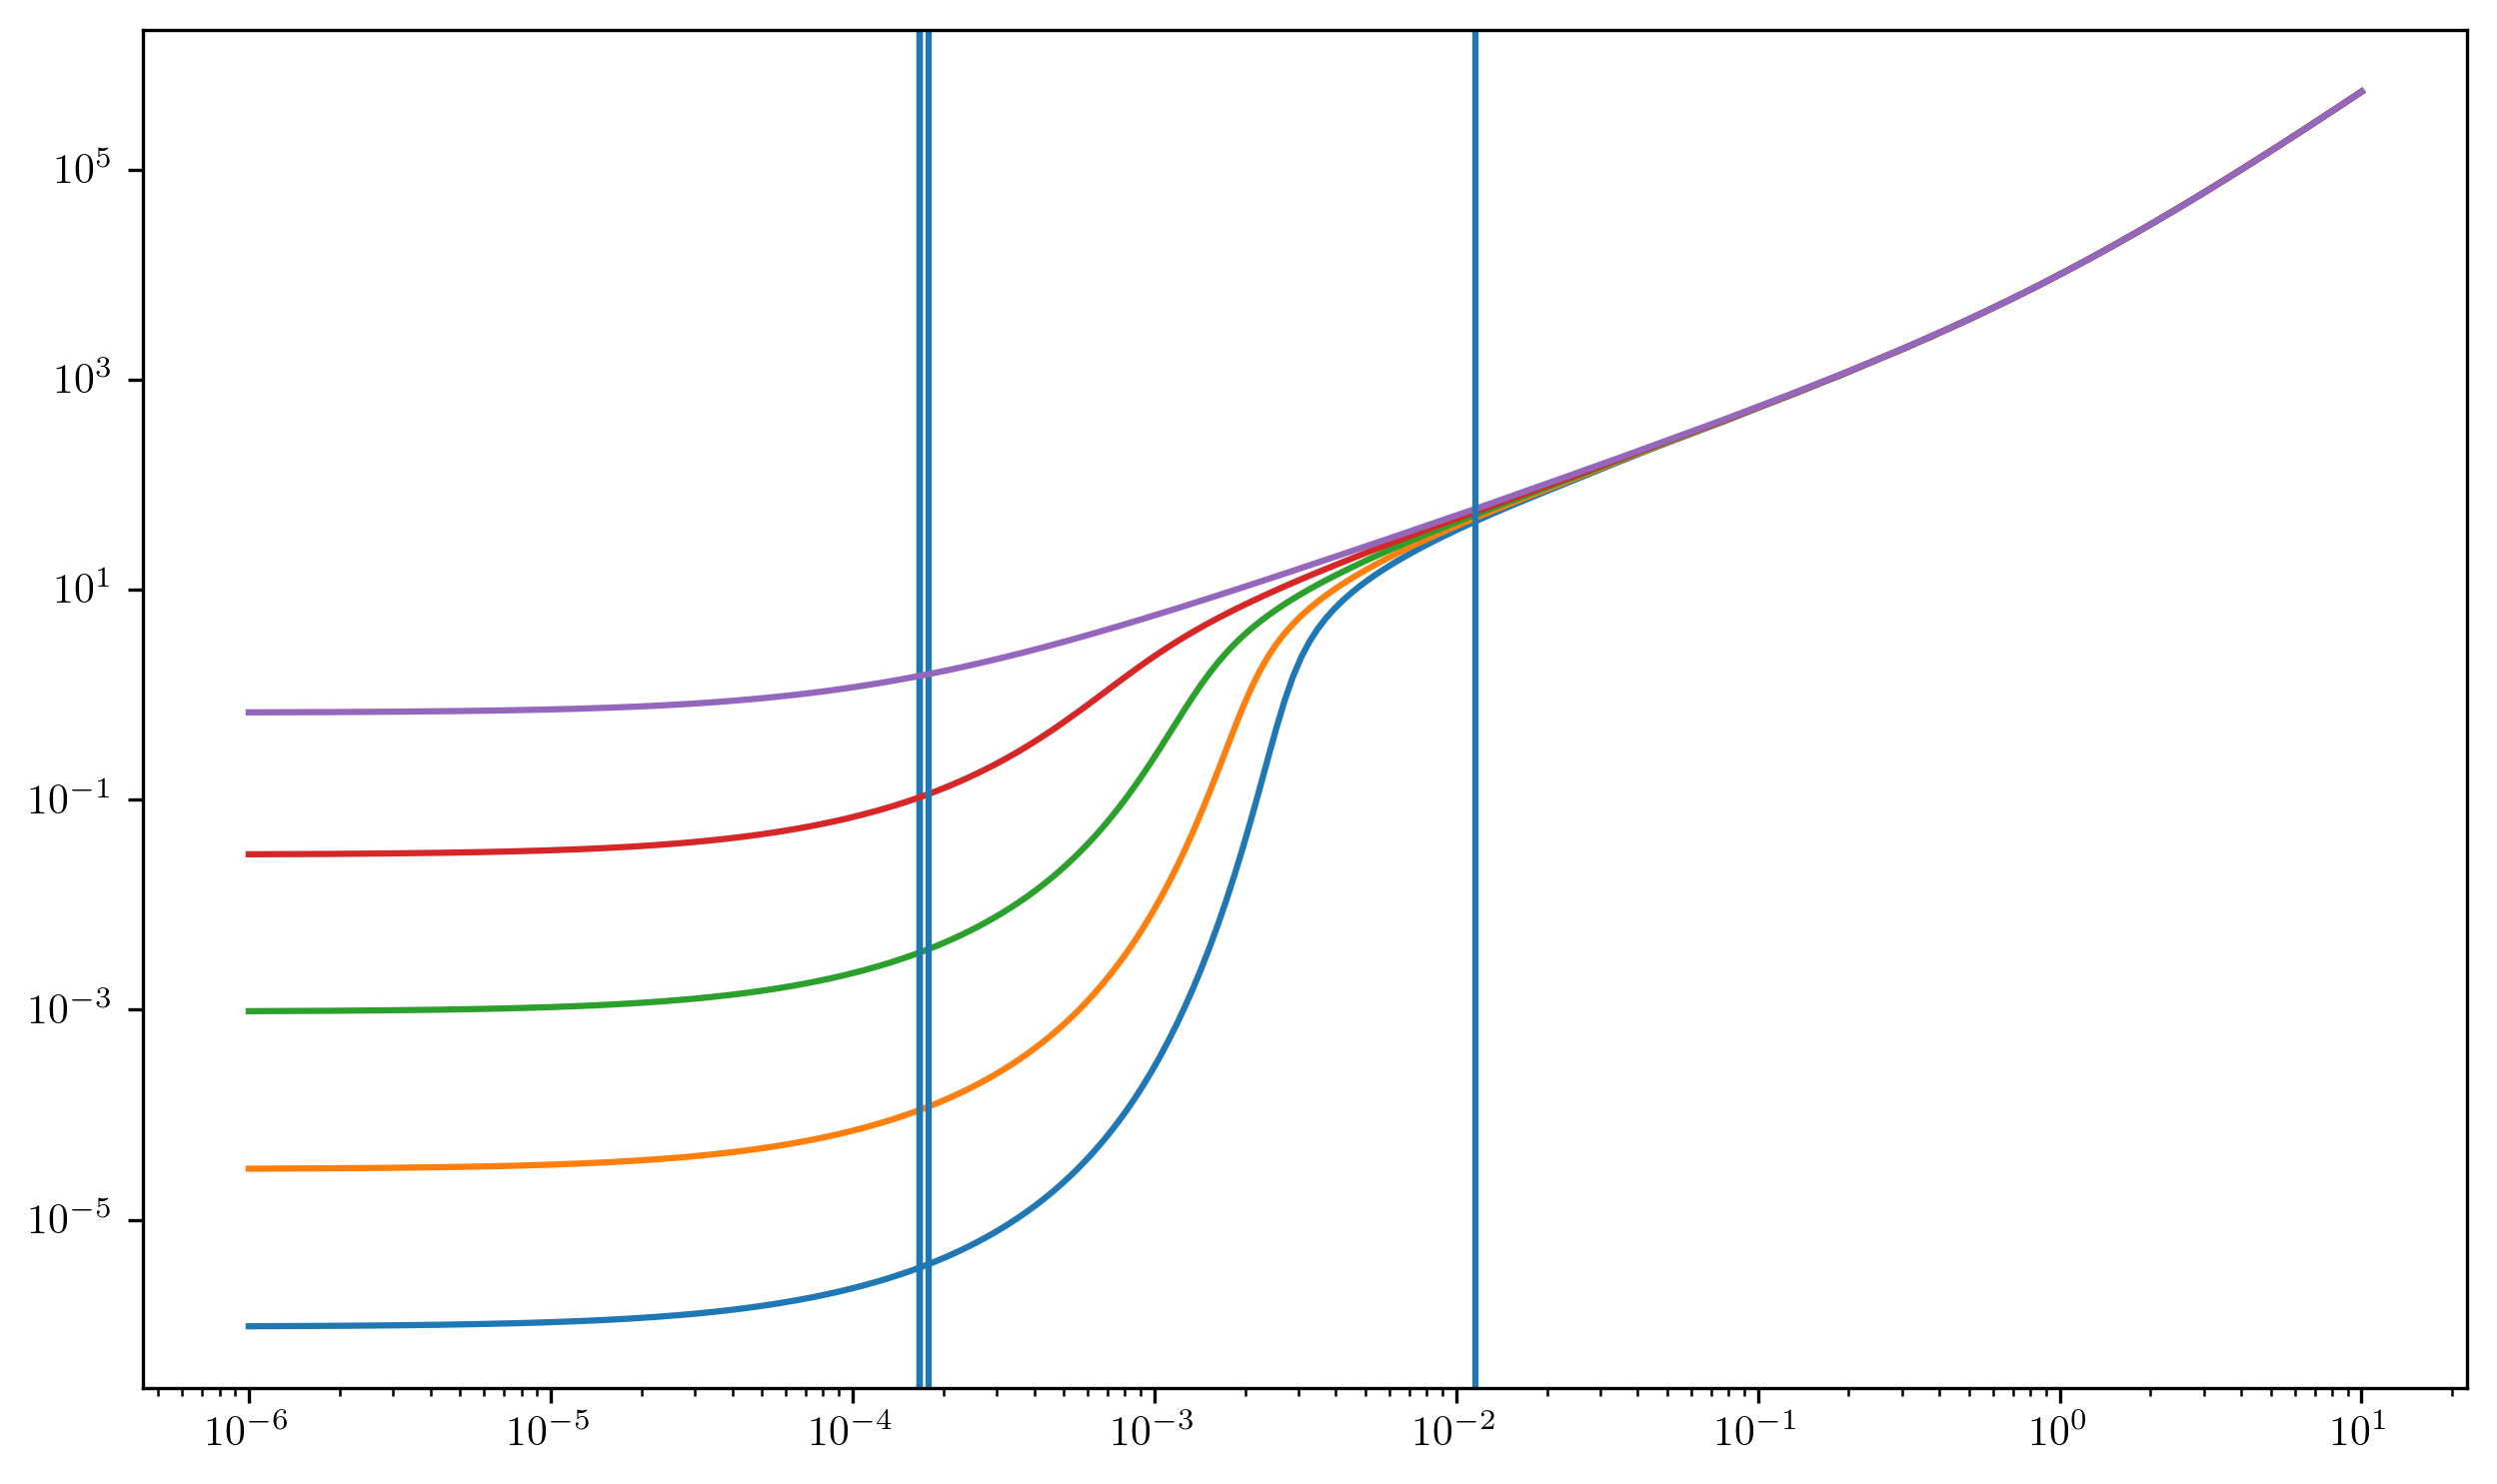

In [51]:
plt.figure(figsize=(10, 6))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
ax = plt.gca()
ax.set_xscale("log")
ax.set_yscale("log")

for log_moments, lambda_vals, best_lambda in zip(all_log_moments, all_lambda_vals, all_best_lambdas):
    plt.plot(lambda_vals, log_moments)
    plt.axvline(best_lambda)

plt.show()

Okay - it seems that even if we look at better range for $\lambda$, we still transition into a new regime when $\sigma$ is too small.